# Dataloader

In [4]:
import numpy as np
import h5py
mat_data = h5py.File("../hcp1003_RestALL_Schaefer_tcCLEAN.mat", "r")

In [5]:
key_name = "FCmats"  # Replace with actual variable name
print(mat_data[key_name])  # Print entire variable (if small)
# print(mat_data[key_name][0])  # Print first 5 elements (if large)
FC_mats = mat_data[key_name]
print(FC_mats.shape)

<HDF5 dataset "FCmats": shape (92, 92, 4, 1001), type "<f8">
(92, 92, 4, 1001)


In [6]:
key_name = "tc_clean"  # Replace with actual variable name
print(mat_data[key_name])  # Print entire variable (if small)
#print(mat_data[key_name][:1])  # Print first 5 elements (if large)

# Select the variable
tc_clean = mat_data[key_name]

# Check shape and type
print(f"Shape: {tc_clean.shape}, Type: {tc_clean.dtype}")

# Check the first reference
first_ref = tc_clean[0, 0]  # Access first HDF5 object reference
print("First reference type:", type(first_ref))

# If it's an object reference, get its name in the HDF5 file
if isinstance(first_ref, h5py.Reference):
    obj = mat_data[first_ref]  # Dereference
    print("Dereferenced object type:", type(obj))
    print("Shape of the object:", obj.shape)
    # print("First few values:", obj[:5])  # Print actual data

num_sessions, num_subjects =  tc_clean.shape
ts_data = [[np.array(mat_data[ref]) for ref in tc_clean[i]] for i in range(num_sessions)]
ts_data = np.transpose(ts_data, (1, 0, 2, 3)) # --> [subjects, sessions, regions, timepoints]
print("Shape of the ts_data:", np.array(ts_data).shape)

<HDF5 dataset "tc_clean": shape (4, 1003), type "|O">
Shape: (4, 1003), Type: object
First reference type: <class 'h5py.h5r.Reference'>
Dereferenced object type: <class 'h5py._hl.dataset.Dataset'>
Shape of the object: (92, 1200)
Shape of the ts_data: (1003, 4, 92, 1200)


## BOLD time series

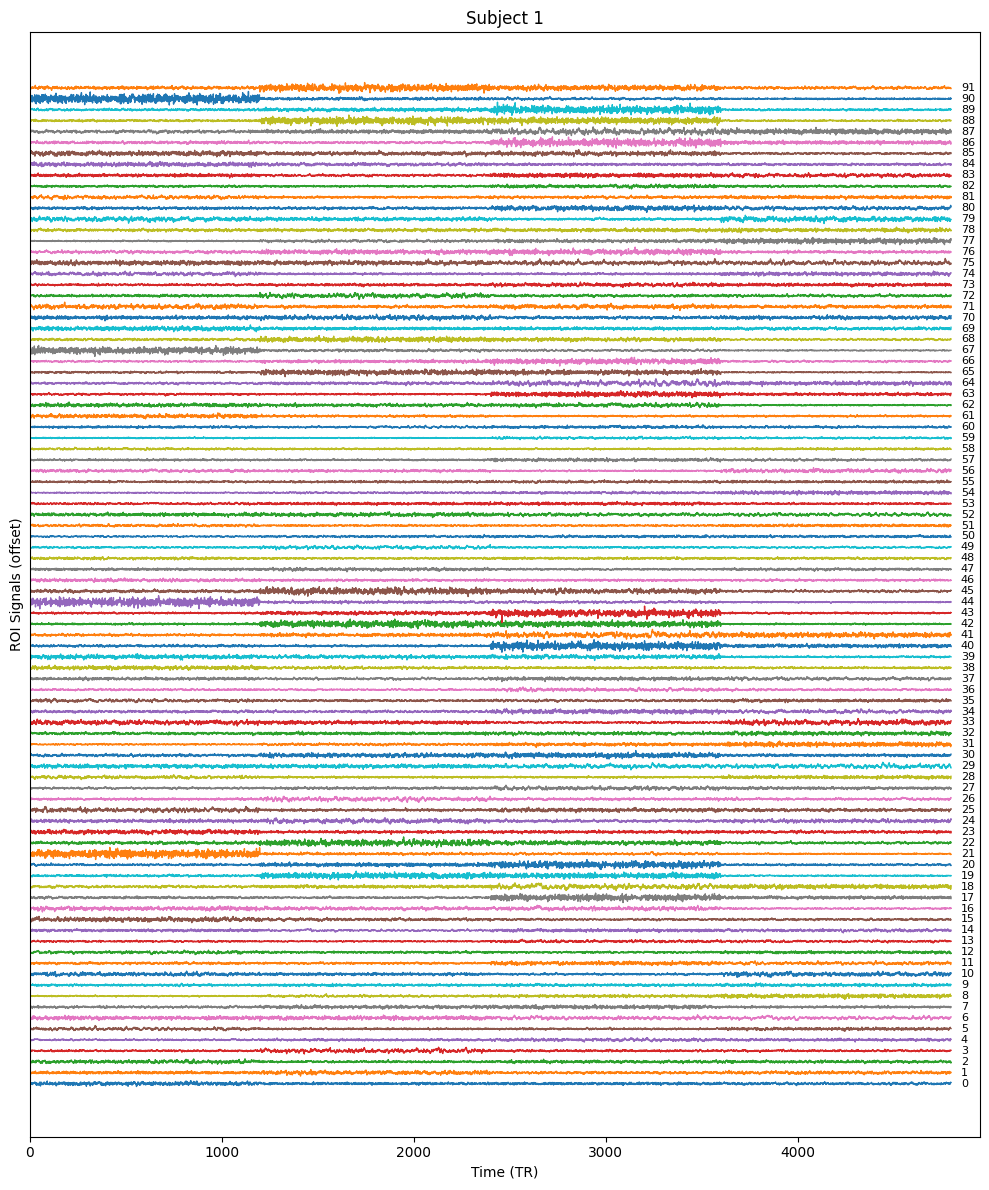

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=[10, 12], dpi=100)

sub_id = 0  
reshaped_data = ts_data[sub_id].reshape(92, 1200 * 4).T  # [4800, 92]

offset = 0
offset_step = 10
signal_length = reshaped_data.shape[0]

for roi_id in range(92):
    signal = reshaped_data[:, roi_id]
    shifted_signal = signal + offset

    plt.plot(shifted_signal, linewidth=1)

    plt.text(signal_length + 50, offset, f'{roi_id}', va='center', fontsize=8)

    offset += offset_step

plt.title(f'Subject {sub_id + 1}')
plt.xlabel('Time (TR)')
plt.ylabel('ROI Signals (offset)')
plt.yticks([])
plt.grid(False)
plt.xlim([0, signal_length + 150])
plt.tight_layout()
plt.show()


## temporal weighted graph

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def compute_temporal_graphs(ts_data, subject_idx=0, selected_sessions=[0], window_size=100, step_size=10):
    """
    Generate temporal graphs using a sliding window approach for selected sessions.

    Parameters:
    ts_data : ndarray
        Time series data of shape [subjects, sessions, regions, timepoints].
    subject_idx : int
        Index of the subject to process.
    selected_sessions : list
        List of session indices to include in analysis.
    window_size : int
        Size of the sliding window.
    step_size : int
        Step size for the sliding window.

    Returns:
    graphs : list
        List of NetworkX graphs representing functional connectivity over time.
    FC_mats : ndarray
        Functional connectivity matrices for visualization.
    """
    subject_data = ts_data[subject_idx]  # Shape: [sessions, regions, timepoints]

    # Concatenate only the selected session timepoints
    combined_timepoints = np.concatenate([subject_data[s] for s in selected_sessions], axis=1)  # Shape: [regions, selected_timepoints]
    total_timepoints = combined_timepoints.shape[1]

    # Normalize time series to avoid zero correlation issues
    combined_timepoints = (combined_timepoints - np.mean(combined_timepoints, axis=1, keepdims=True)) / np.std(combined_timepoints, axis=1, keepdims=True)

    # Compute the correct number of graphs
    num_graphs = (total_timepoints - window_size) // step_size + 1
    FC_mats = np.zeros((combined_timepoints.shape[0], combined_timepoints.shape[0], num_graphs))

    graphs = []
    graph_idx = 0
    for start in range(0, total_timepoints - window_size + 1, step_size):
        window = combined_timepoints[:, start:start + window_size]  # Shape: [regions, window_size]

        # Compute functional connectivity (Pearson correlation) correctly
        corr_matrix = np.corrcoef(window, rowvar=True)  # Correlation across regions
        np.fill_diagonal(corr_matrix, 0)  # Remove self-connections

        FC_mats[:, :, graph_idx] = corr_matrix  # Store at correct index

        # Create a graph
        G = nx.from_numpy_array(corr_matrix)
        graphs.append(G)

        graph_idx += 1

    return graphs, FC_mats

def visualize_fc_matrices(FC_mats, SS):
    """Visualize functional connectivity matrices for selected timepoints with adjusted color bar length."""
    plt.figure(figsize=(12, 6))
    num_plots = len(SS)
    for s, timepoint in enumerate(SS):
        ax = plt.subplot(1, num_plots, s + 1)
        im = ax.imshow(FC_mats[:, :, timepoint], cmap='jet', vmin=-1, vmax=1)
        ax.set_title(f'Timepoint {timepoint}')

        # Adjust color bar to match graph size
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.show()

selected_sessions = [0]  # Select only session 1
temporal_graphs, FC_mats = compute_temporal_graphs(ts_data, subject_idx=1, selected_sessions=selected_sessions, window_size=100, step_size=10)

In [125]:
print(len(temporal_graphs), type(temporal_graphs), type(FC_mats))

111 <class 'list'> <class 'numpy.ndarray'>


In [126]:
print(np.array(temporal_graphs).shape)
print(FC_mats.shape)

(111, 92)
(92, 92, 111)


In [8]:
weighted_graph = np.transpose(FC_mats,(2, 0, 1))
print(weighted_graph.shape)

(111, 92, 92)


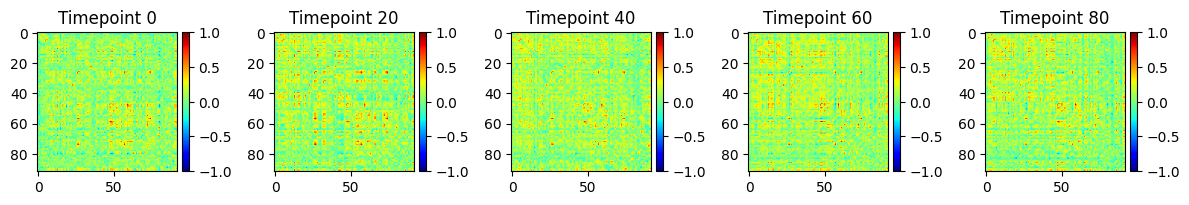

In [212]:
SS = [0, 20, 40, 60, 80]
visualize_fc_matrices(FC_mats, SS)

## binary graph

In [8]:
import numpy as np
import networkx as nx

def compute_binary_temporal_graphs(FC_mats, threshold=0.1):
    """
    Compute binary adjacency matrices from functional connectivity matrices.

    Parameters:
    FC_mats : ndarray
        Functional connectivity matrices over time (shape: [regions, regions, timepoints]).
    threshold : float
        Threshold to binarize the correlation matrix.

    Returns:
    binary_matrices : list
        List of binary adjacency matrices (numpy arrays) over time.
    """
    binary_matrices = []

    for i in range(FC_mats.shape[2]):  # Iterate over time points
        correlation_matrix = FC_mats[:, :, i]

        # Convert to binary adjacency matrix using the threshold
        binary_matrix = (np.abs(correlation_matrix) > threshold).astype(int)

        # Store binary matrix
        binary_matrices.append(binary_matrix)

    return np.array(binary_matrices)

binary_temporal_graphs = compute_binary_temporal_graphs(FC_mats, threshold=0.4)
binary_temporal_graphs[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], shape=(92, 92))

In [10]:
binary_temporal_graphs_len = len(binary_temporal_graphs)
print(len(binary_temporal_graphs), binary_temporal_graphs.shape)

111 (111, 92, 92)


## TEA plot

### original TEA

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_tea_plot(dynfc_matrices_list, session_idx, thresholds):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (threshold, dynfc_matrices) in enumerate(zip(thresholds, dynfc_matrices_list)):
        row, col = divmod(idx, 2)
        graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

        repeated_edges = [0]
        new_graph = nx.Graph()
        for i in range(1, len(graph_list)):
            new_graph = nx.compose(new_graph, graph_list[i-1])
            repeated_edges.append(nx.intersection(new_graph, graph_list[i]).number_of_edges())

        num_edges = [np.count_nonzero(matrix) // 2 for matrix in dynfc_matrices]
        new_edges = [num_edges[i] - repeated_edges[i] for i in range(len(num_edges))]
        # new_edge_ratios = [new_edges[i] / num_edges[i] if num_edges[i] > 0 else 0 for i in range(len(num_edges))]

        repeated_edges[0] = 0
        new_edges[0] = num_edges[0]
        
        ax1 = axes[row, col]
        x_vals = np.arange(len(repeated_edges))
        ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
        ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Number of Edges', fontsize=12)
        ax1.legend(loc='upper left', fontsize=10)
        ax1.set_title(f'Threshold: {threshold}', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
    
    
    plt.tight_layout()
    plt.show()

### TEA with noise

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_tea_plot_th(dynfc_matrices, session_idx, min_v):
    graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

    repeated_edges = [0]  
    new_edges = [len(graph_list[0].edges)]  
    new_edge_ratios = [1.0]  

    prev_graph = nx.Graph()  

    for i in range(len(graph_list)):
        current_graph = graph_list[i]

        repeated_count = 0
        for u, v, weight in current_graph.edges(data=True):
            if prev_graph.has_edge(u, v):
                prev_weight = prev_graph[u][v]['weight']
                if abs(weight['weight'] - prev_weight) <= min_v:
                    repeated_count += 1

        repeated_edges.append(repeated_count)
        new_count = len(current_graph.edges) - repeated_count
        new_edges.append(new_count)
        
        total_edges = len(current_graph.edges)
        new_edge_ratios.append(new_count / total_edges if total_edges > 0 else 0)

        prev_graph = current_graph

    x_vals = np.arange(len(repeated_edges))
    
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
    ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('Number of Edges', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left', fontsize=14)
    ax1.set_title(f'Temporal Edge Analysis Over Time (Session {session_idx + 1})', fontsize=18)
    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    
    ax2 = ax1.twinx()
    ax2.plot(x_vals, new_edge_ratios, color='black', marker='o', linestyle='-', linewidth=2, markersize=6, label="New Edge Ratio")
    ax2.set_ylabel('Proportion of New Edges', fontsize=16, color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper right', fontsize=14)
    
    plt.show()

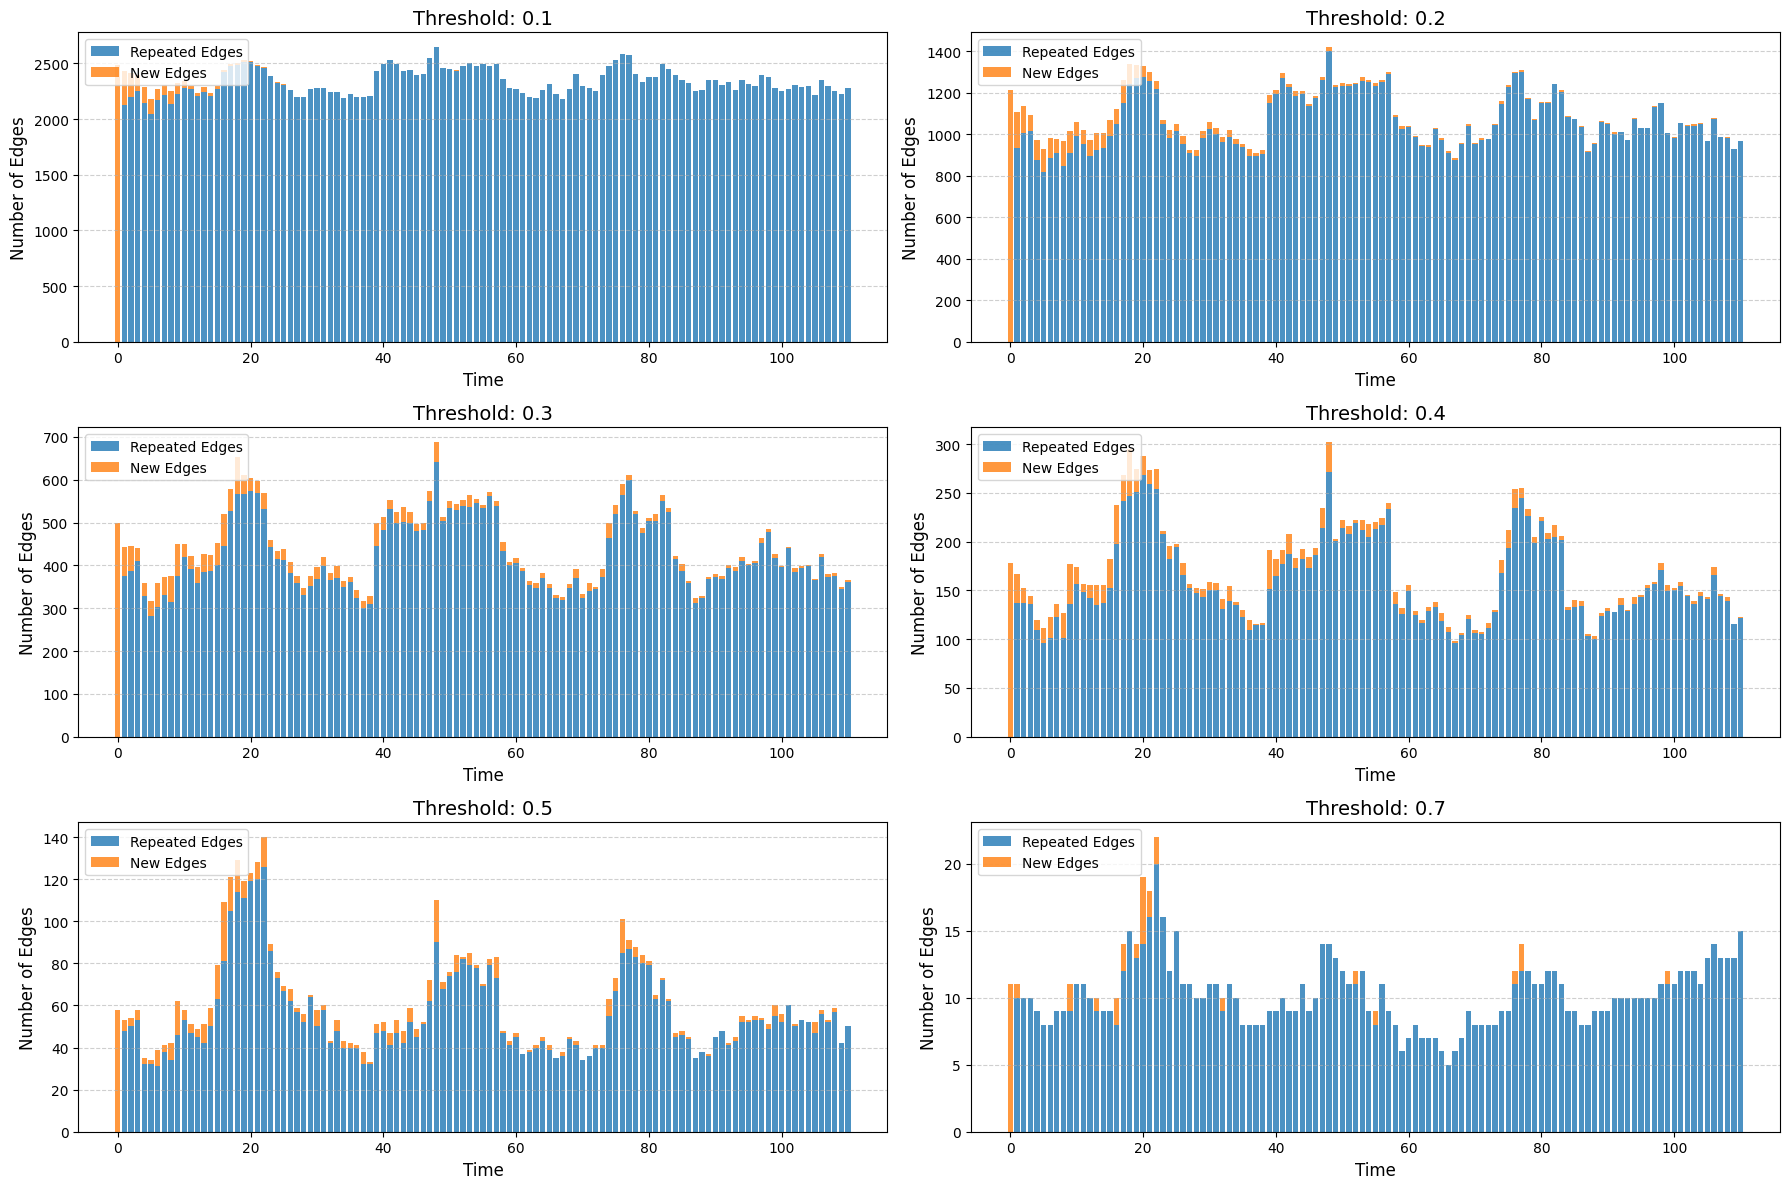

In [141]:
thresh_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)
# change more in the beginning in threshold 0.2, more regione become connected

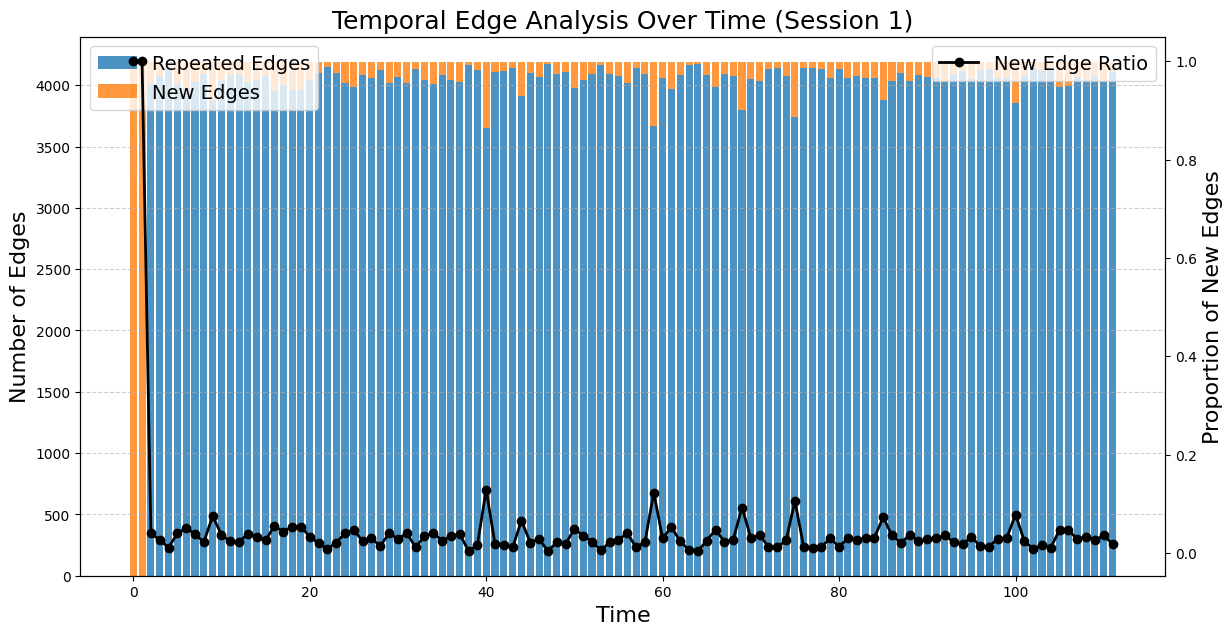

In [144]:
plot_tea_plot_th(weighted_graph, 0, 0.12)
# showing when the brain will change more, filter the noise that under the threshold.

### TEA with novelty

In [26]:
import numpy as np
import networkx as nx

# Function to compute novelty index for a single session
def compute_novelty_index(dynfc_matrices):
    novelty_indices = []
    seen_edges = set()

    for matrix in dynfc_matrices:
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        new_edges = current_edges - seen_edges
        total_edges = len(current_edges)

        if total_edges > 0:
            novelty_index = len(new_edges) / total_edges
        else:
            novelty_index = 0

        novelty_indices.append(novelty_index)
        seen_edges.update(current_edges)

    # Calculate average novelty index for the session
    average_novelty_index = np.mean(novelty_indices)
    return novelty_indices, average_novelty_index

# Compute novelty index for each session and the average novelty index
novelty_indices_per_session = []
average_novelty_indices = []

session_dynfc_matrices = binary_temporal_graphs
novelty_indices, average_novelty_index = compute_novelty_index(session_dynfc_matrices)

novelty_indices_per_session.append(novelty_indices)
average_novelty_indices.append(average_novelty_index)

# Print results for the current session
print(f"Session {0 + 1}:")
print(f"Novelty Indices: {novelty_indices}")
print(f"Average Novelty Index: {average_novelty_index}\n")

# Print average novelty indices for all sessions
print("Average Novelty Index for Each Session:")
print(average_novelty_indices)


Session 1:
Novelty Indices: [1.0, 0.17964071856287425, 0.09868421052631579, 0.05555555555555555, 0.09166666666666666, 0.13513513513513514, 0.17886178861788618, 0.09558823529411764, 0.2047244094488189, 0.23163841807909605, 0.09770114942528736, 0.05732484076433121, 0.08974358974358974, 0.1346153846153846, 0.11612903225806452, 0.16483516483516483, 0.16455696202531644, 0.09701492537313433, 0.16271186440677965, 0.08394160583941605, 0.06944444444444445, 0.05128205128205128, 0.072992700729927, 0.014218009478672985, 0.06666666666666667, 0.020202020202020204, 0.06741573033707865, 0.03184713375796178, 0.03289473684210526, 0.052980132450331126, 0.05660377358490566, 0.05063291139240506, 0.07092198581560284, 0.09740259740259741, 0.021739130434782608, 0.05384615384615385, 0.09166666666666666, 0.017241379310344827, 0.02564102564102564, 0.2094240837696335, 0.09340659340659341, 0.07329842931937172, 0.10096153846153846, 0.0546448087431694, 0.052083333333333336, 0.059782608695652176, 0.03626943005181347,

In [27]:
for i in range(len(novelty_indices)):
    if novelty_indices[i] > 0.2:
        print(i, " ")

0  
8  
9  
39  


#### adaptive lookback

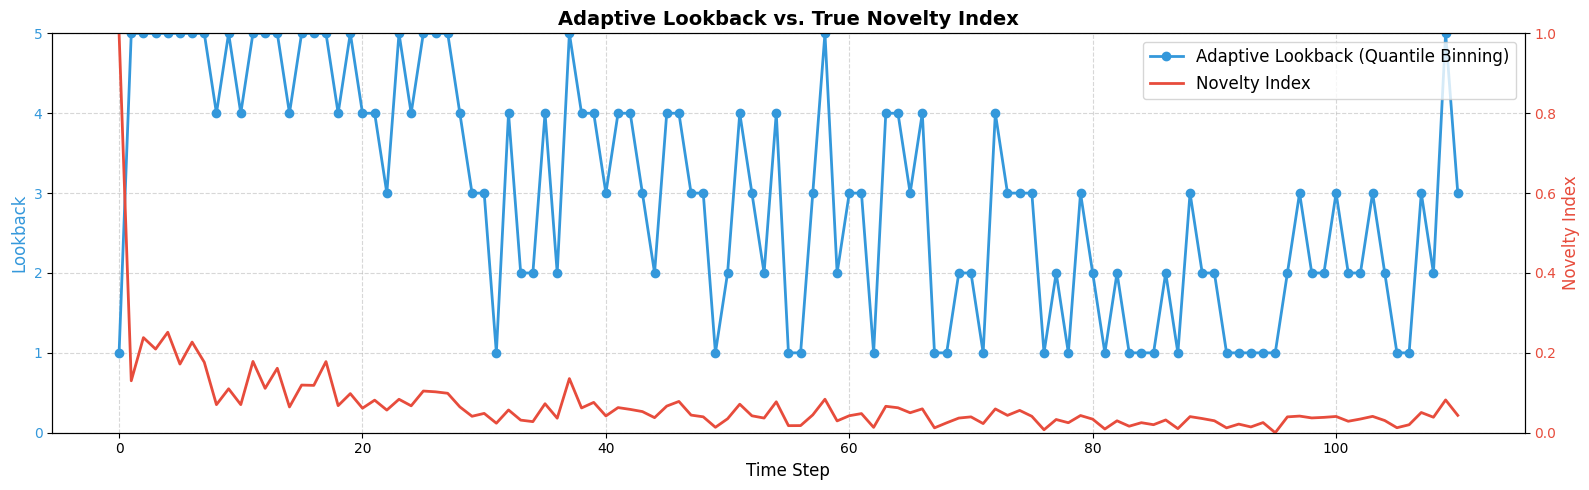

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Ignore the first value
novelty_indices_wo_first = novelty_indices[1:]

# Quantile binning function
def quantile_binning(novelties, min_lookback=1, max_lookback=5):
    novelties = np.array(novelties)
    num_bins = max_lookback - min_lookback + 1
    quantiles = np.quantile(novelties, np.linspace(0, 1, num_bins + 1))

    lookbacks = []
    for n in novelties:
        for i in range(num_bins):
            if quantiles[i] <= n <= quantiles[i + 1]:
                lookbacks.append(min_lookback + i)
                break
    return lookbacks

# Recompute lookbacks
adaptive_lookbacks_wo_first = quantile_binning(novelty_indices_wo_first)
adaptive_lookbacks = [1] + adaptive_lookbacks_wo_first


# Plot using original (unsmoothed) novelty values
fig, ax1 = plt.subplots(figsize=(16, 5))

# Left y-axis: Lookback
ax1.set_xlabel("Time Step", fontsize=12)
ax1.set_ylabel("Lookback", fontsize=12, color="#3498DB")
ax1.plot(adaptive_lookbacks, label="Adaptive Lookback (Quantile Binning)", color="#3498DB", marker="o", linewidth=2)
ax1.tick_params(axis='y', labelcolor="#3498DB")
ax1.set_ylim(0, 5)

# Right y-axis: true novelty values scaled to match visual range
ax2 = ax1.twinx()
ax2.set_ylabel("Novelty Index", fontsize=12, color="#E74C3C")
ax2.plot(np.array(novelty_indices) * 5, label="Novelty Index", color="#E74C3C", linewidth=2)
ax2.set_ylim(0, 5)
ax2_ticks = np.linspace(0, 5, 6)
ax2.set_yticks(ax2_ticks)
ax2.set_yticklabels([f"{tick / 5:.1f}" for tick in ax2_ticks])
ax2.tick_params(axis='y', labelcolor="#E74C3C")

# Title and grid
plt.title("Adaptive Lookback vs. True Novelty Index", fontsize=14, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()


#### plotting with novelty

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.interpolate import make_interp_spline

def compute_novelty_index(dynfc_matrices):
    novelty_indices = []
    seen_edges = set()

    for matrix in dynfc_matrices:
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        new_edges = current_edges - seen_edges
        total_edges = len(current_edges)

        novelty_index = len(new_edges) / total_edges if total_edges > 0 else 0
        novelty_indices.append(novelty_index)
        seen_edges.update(current_edges)

    average_novelty_index = np.mean(novelty_indices) if novelty_indices else 0

    return novelty_indices, average_novelty_index

def plot_tea_plot(dynfc_matrices_list, session_idx, thresholds):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (threshold, dynfc_matrices) in enumerate(zip(thresholds, dynfc_matrices_list)):
        row, col = divmod(idx, 2)
        graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

        repeated_edges = [0]
        new_graph = nx.Graph()
        for i in range(1, len(graph_list)):
            new_graph = nx.compose(new_graph, graph_list[i-1])
            repeated_edges.append(nx.intersection(new_graph, graph_list[i]).number_of_edges())

        num_edges = [np.count_nonzero(matrix) // 2 for matrix in dynfc_matrices]
        new_edges = [num_edges[i] - repeated_edges[i] for i in range(len(num_edges))]
        novelty_indices, average_novelty_index = compute_novelty_index(dynfc_matrices)

        repeated_edges[0] = 0
        new_edges[0] = num_edges[0]

        ax1 = axes[row, col]
        x_vals = np.arange(len(repeated_edges))
        ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
        ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Number of Edges', fontsize=12)
        ax1.legend(loc='upper left', fontsize=10)
        ax1.set_title(f'Threshold: {threshold} (Avg. Novelty: {average_novelty_index:.2f})', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
        
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 10))
        
        # Smoothing the novelty index curve with a thinner red color
        if len(x_vals) > 1:
            x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)
            novelty_smooth = make_interp_spline(x_vals, novelty_indices, k=3)(x_smooth)
            ax3.plot(x_smooth, novelty_smooth, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        else:
            ax3.plot(x_vals, novelty_indices, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        
        ax3.set_ylabel('Novelty Index', fontsize=12, color='red')
        ax3.tick_params(axis='y', labelcolor='red')
        ax3.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.show()


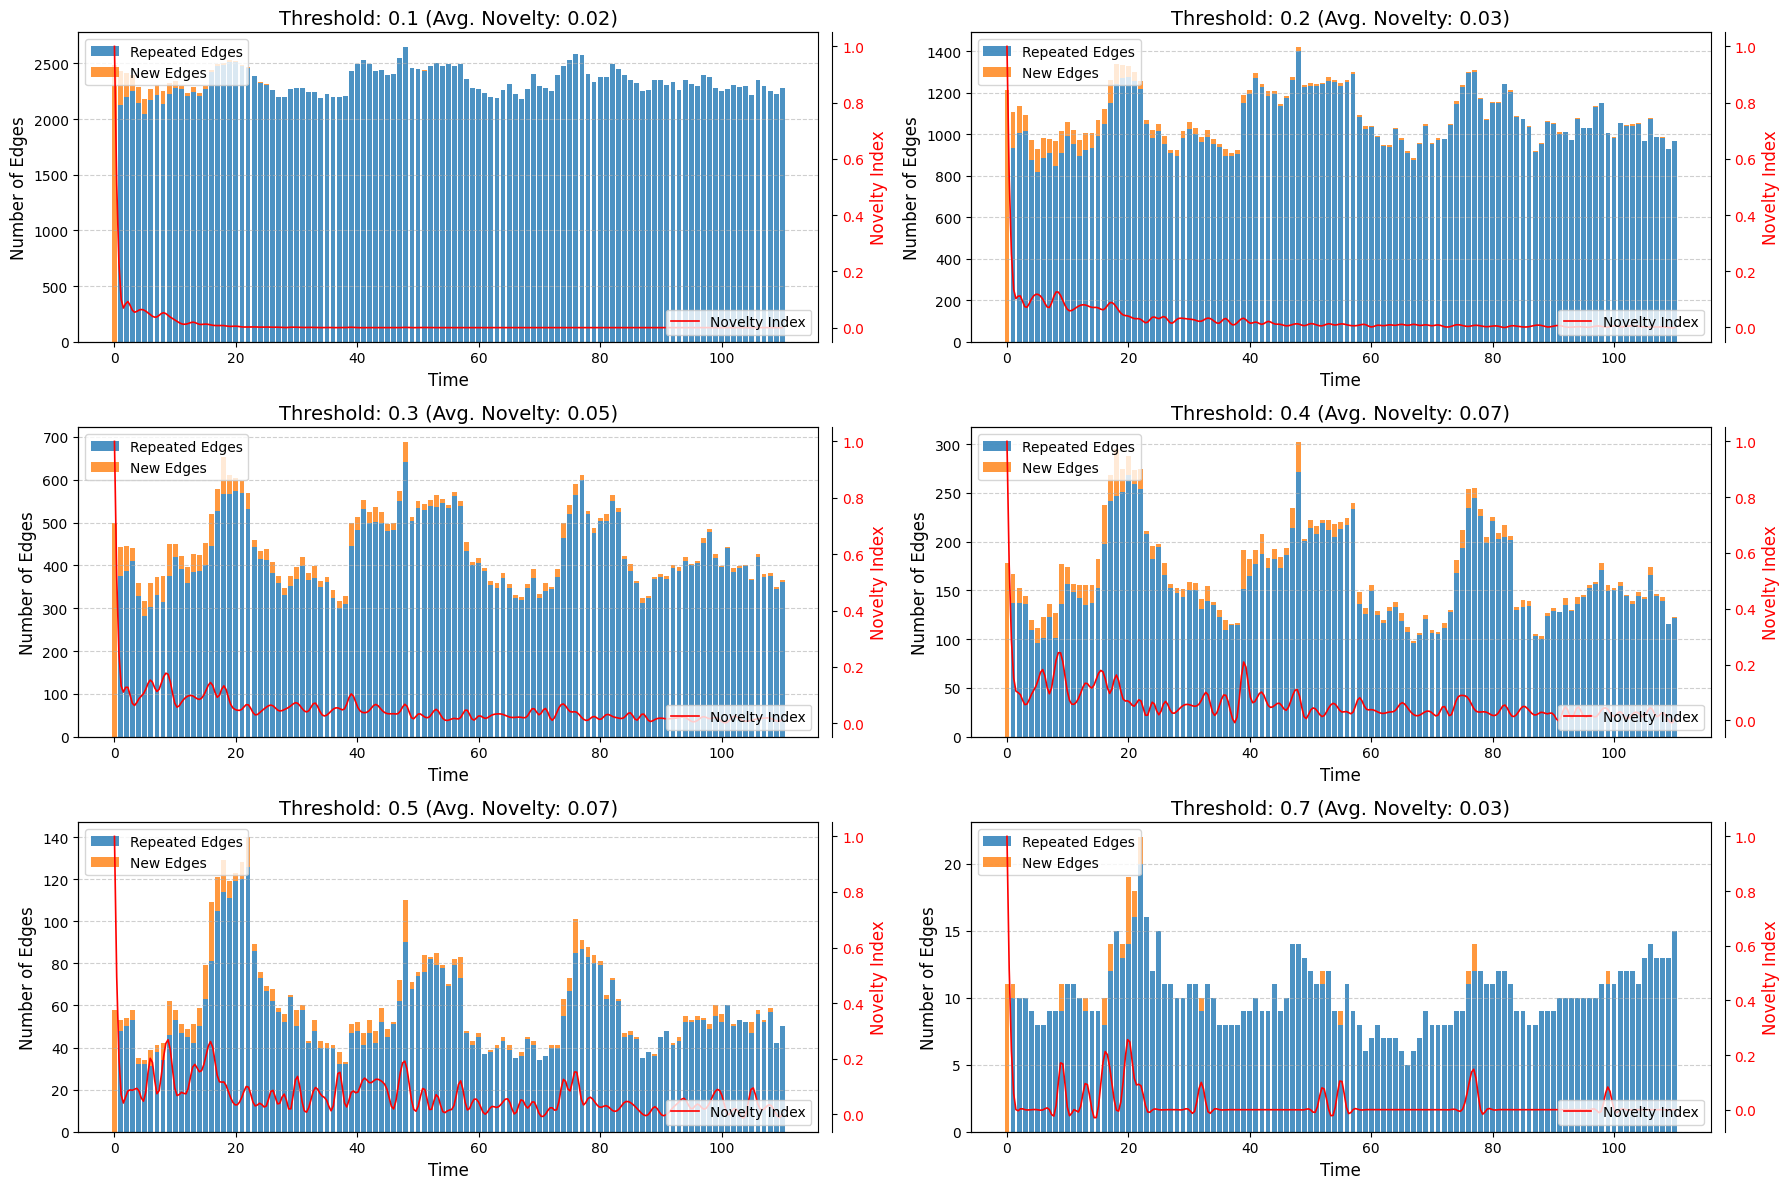

In [29]:
thresh_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)
# change more in the beginning in threshold 0.2, more regione become connected

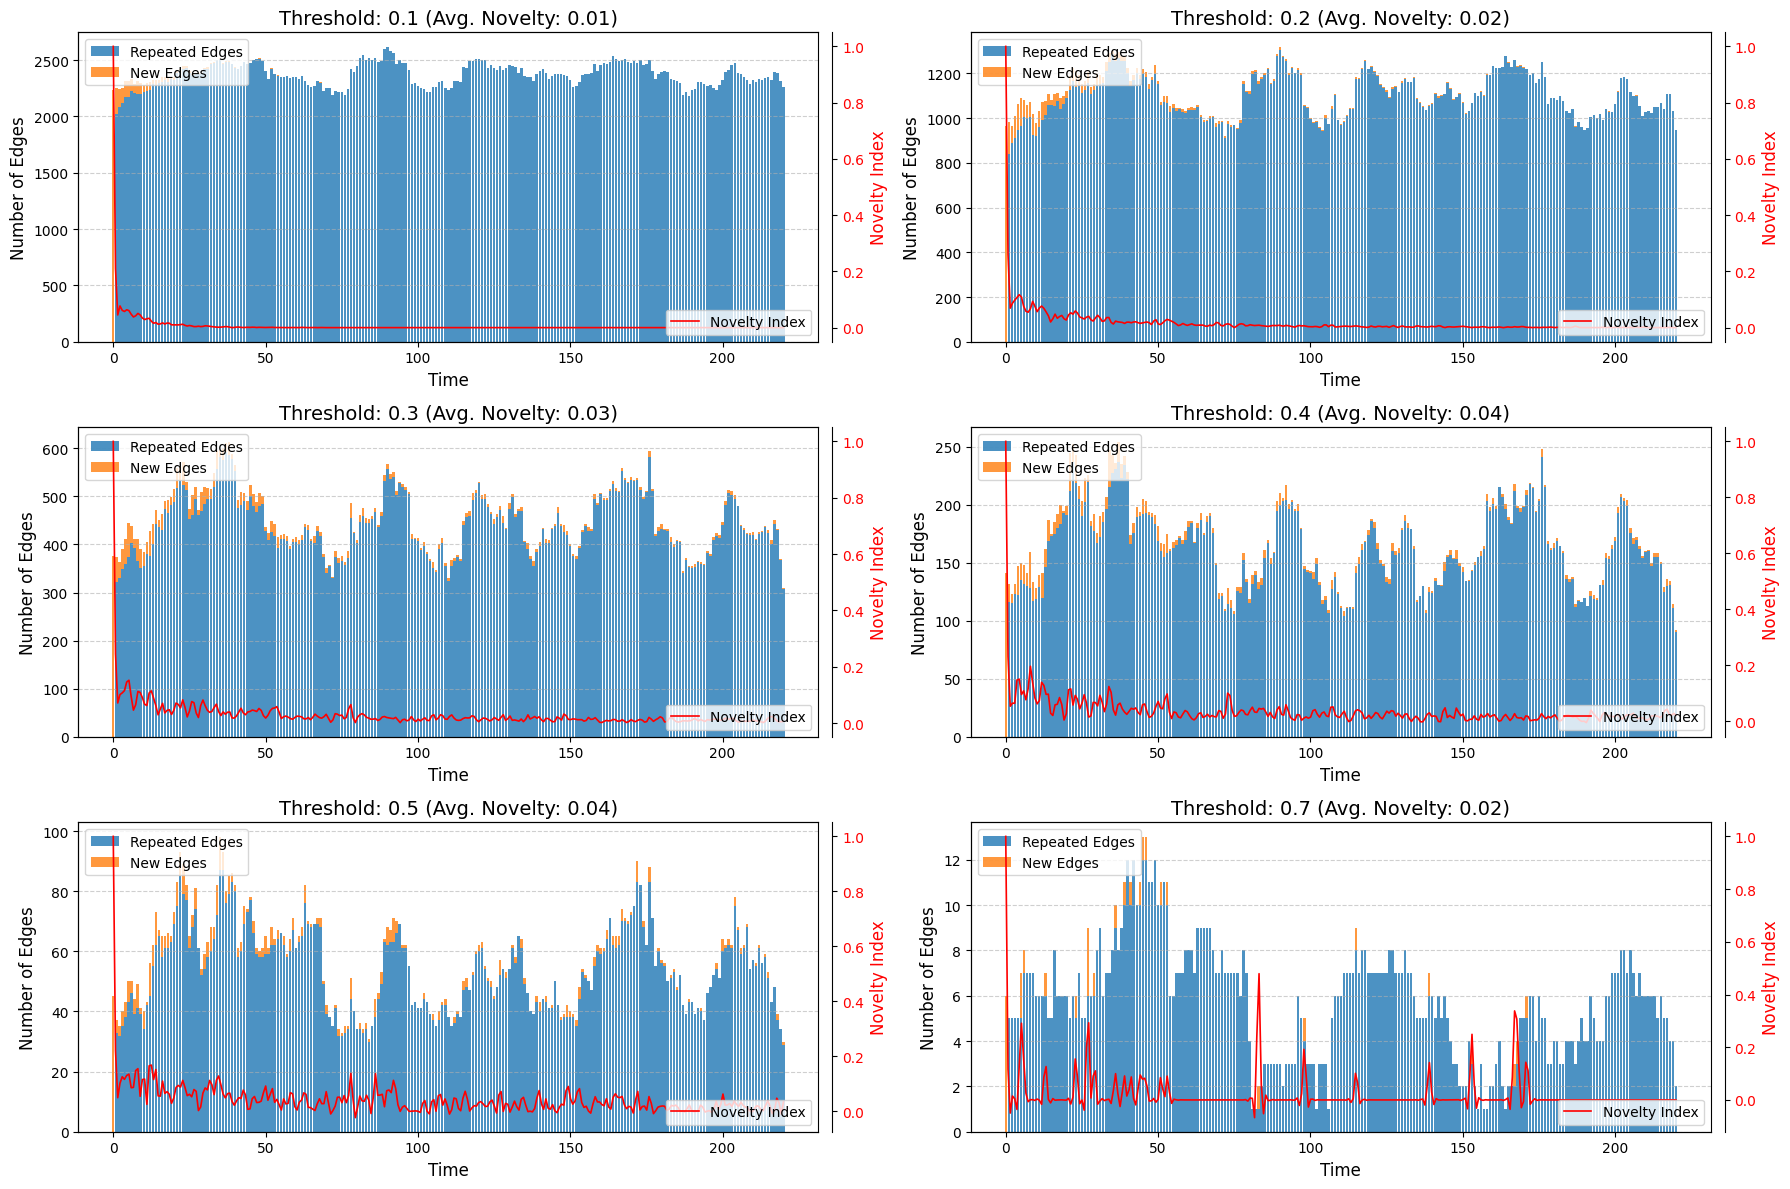

In [79]:
thresh_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)
# change more in the beginning in threshold 0.2, more regione become connected

#### TEA of all subjects

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.interpolate import make_interp_spline

def compute_novelty_index(dynfc_matrices):
    novelty_indices = []
    seen_edges = set()
    for matrix in dynfc_matrices:
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())
        new_edges = current_edges - seen_edges
        total_edges = len(current_edges)
        novelty_index = len(new_edges) / total_edges if total_edges > 0 else 0
        novelty_indices.append(novelty_index)
        seen_edges.update(current_edges)
    return novelty_indices, np.mean(novelty_indices)

def compute_stats_across_subjects(subject_graphs_list): # for single threshold
    num_subjects = len(subject_graphs_list) # 1003
    num_timepoints = len(subject_graphs_list[0]) # 111
    edge_counts_all = np.zeros((num_subjects, num_timepoints)) # (1003, 111)
    novelty_indices_all = np.zeros((num_subjects, num_timepoints)) # (1003, 111)
    for subj_idx, dynfc_matrices in enumerate(subject_graphs_list):
        novelty_indices, _ = compute_novelty_index(dynfc_matrices)
        edge_counts = [np.count_nonzero(mat) // 2 for mat in dynfc_matrices]
        edge_counts_all[subj_idx] = edge_counts
        novelty_indices_all[subj_idx] = novelty_indices
    return (edge_counts_all.mean(0), edge_counts_all.std(0),
            novelty_indices_all.mean(0), novelty_indices_all.std(0))

def plot_mean_tea_subplot(threshold_stats, thresholds):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    for idx, (threshold, stats) in enumerate(zip(thresholds, threshold_stats)):
        row, col = divmod(idx, 2)
        edge_mean, edge_std, novelty_mean, novelty_std = stats
        x_vals = np.arange(len(edge_mean))
        ax1 = axes[row, col]

        ax1.bar(x_vals, edge_mean, color='#1f77b4', alpha=0.8, label='Mean Edges')
        ax1.fill_between(x_vals, edge_mean - edge_std, edge_mean + edge_std,
                         color='#1f77b4', alpha=0.3, label='Edge Variance')

        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Number of Edges', fontsize=12)
        ax1.set_title(f'Threshold: {threshold} (Avg. Novelty: {np.mean(novelty_mean):.2f})', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)

        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('outward', 10))
        x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)
        novelty_smooth = make_interp_spline(x_vals, novelty_mean, k=3)(x_smooth)
        novelty_upper = make_interp_spline(x_vals, novelty_mean + novelty_std, k=3)(x_smooth)
        novelty_lower = make_interp_spline(x_vals, novelty_mean - novelty_std, k=3)(x_smooth)

        ax2.plot(x_smooth, novelty_smooth, color='red', linewidth=1.2, label='Novelty Index')
        ax2.fill_between(x_smooth, novelty_lower, novelty_upper, color='red', alpha=0.2, label='Novelty Variance')

        ax2.set_ylabel('Novelty Index', fontsize=12, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
    plt.tight_layout()
    plt.show()


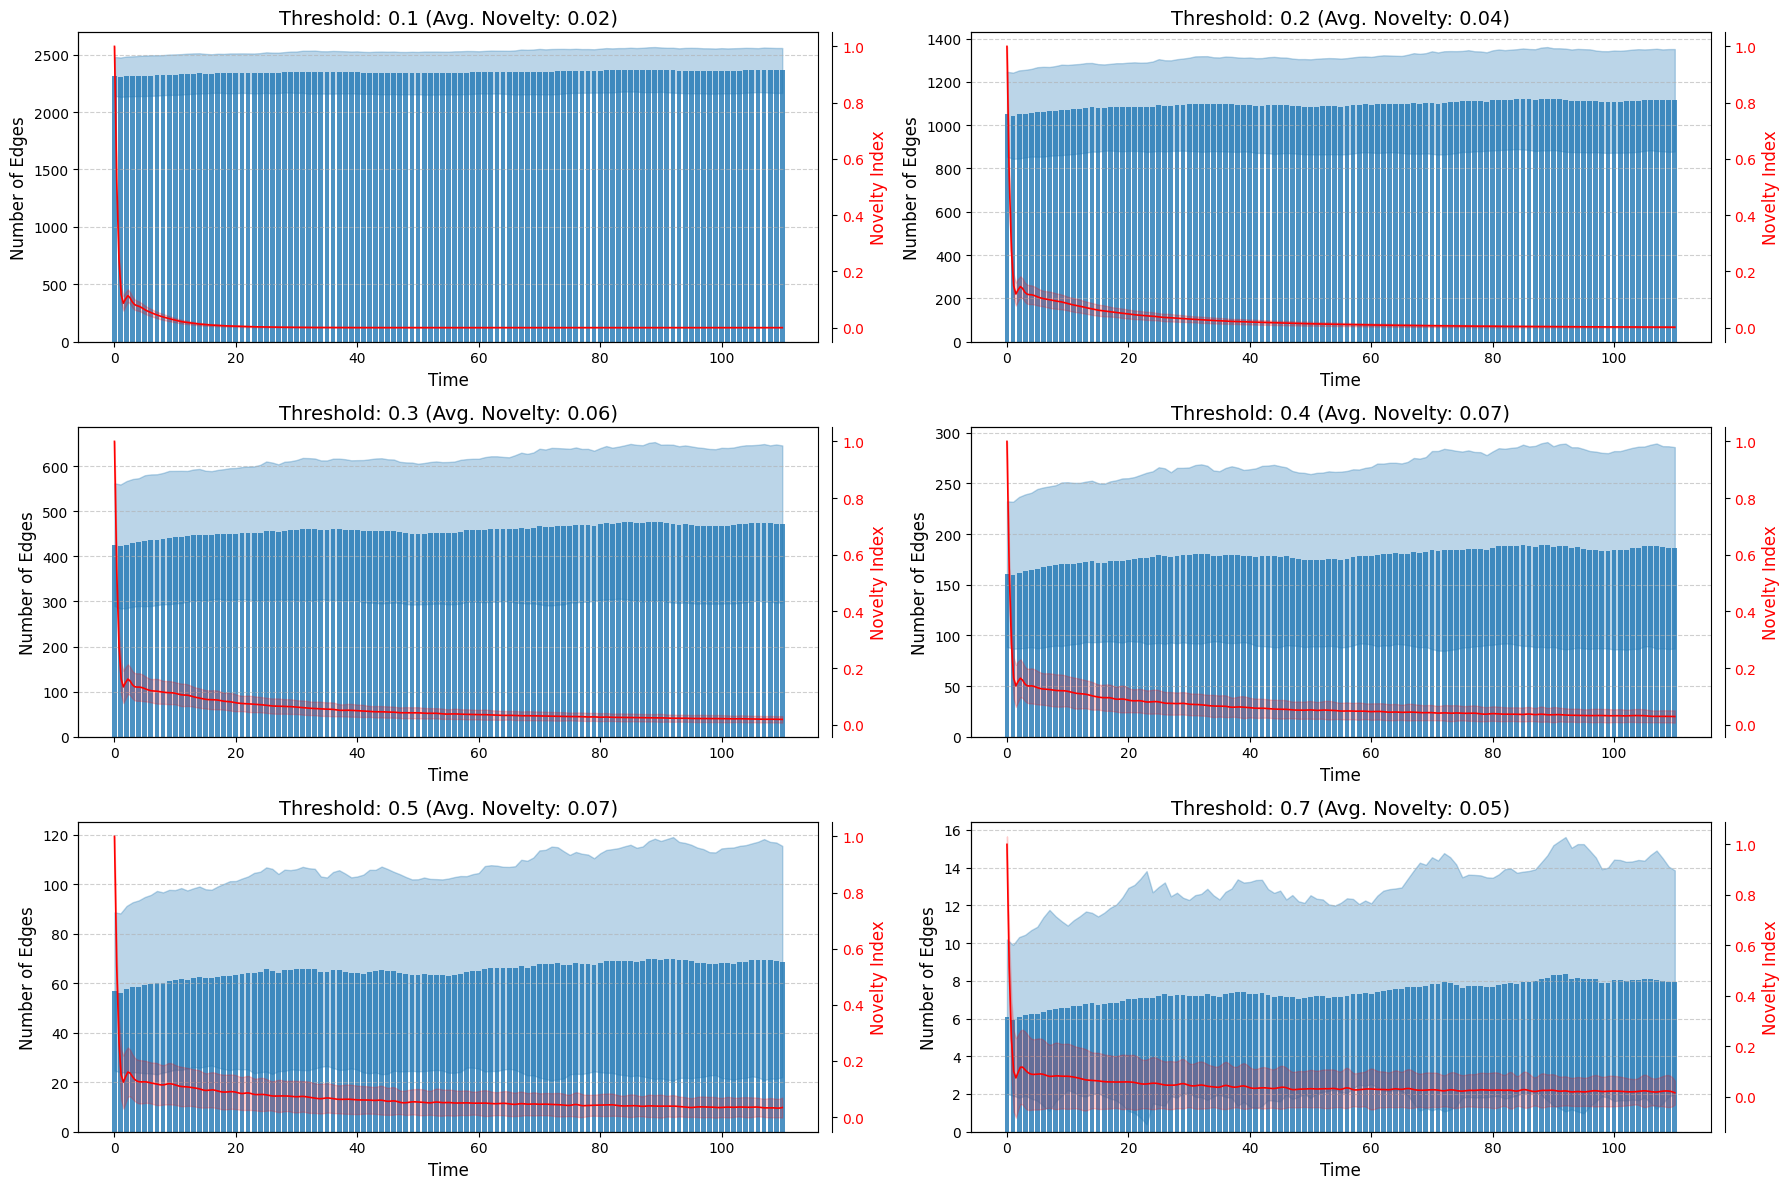

In [56]:
threshold_graphs_all_subjects = [[] for _ in range(len(thresh_list))]
selected_sessions = [0]

for subj_idx in range(len(ts_data)):  
    temporal_graphs, FC_mats = compute_temporal_graphs(ts_data, subject_idx=subj_idx, selected_sessions=selected_sessions, window_size=100, step_size=10)
    for i, threshold in enumerate(thresh_list):
        binary_graphs = compute_binary_temporal_graphs(FC_mats, threshold)
        threshold_graphs_all_subjects[i].append(binary_graphs)

threshold_stats = []
for subject_graphs in threshold_graphs_all_subjects:
    stats = compute_stats_across_subjects(subject_graphs)
    threshold_stats.append(stats)

plot_mean_tea_subplot(threshold_stats, thresh_list)


## Visualization

### Brain Atlas(Schaefer 2018)

[get_dataset_dir] Dataset found in data/schaefer_2018

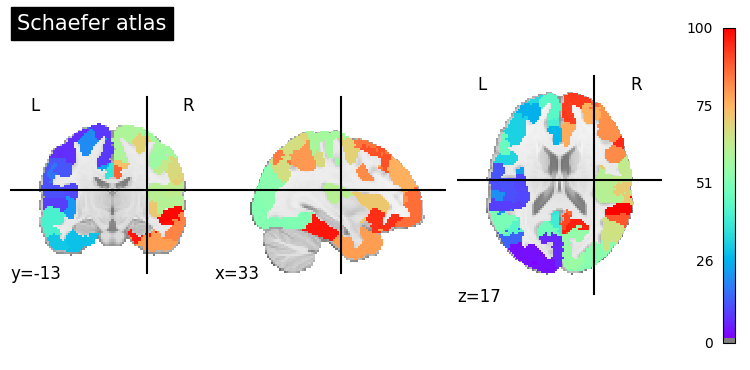

In [121]:
from nilearn import datasets, plotting, image

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=17, resolution_mm=2, data_dir='data')
atlas_map = atlas['maps']
roi_labels = atlas['labels']
atlas_img = image.load_img(atlas_map)

# Plot the brain rois
plotting.plot_roi(atlas_map, title="Schaefer atlas", cmap = 'rainbow', alpha=1, draw_cross=True, colorbar=True, annotate=True)

In [127]:
import numpy as np

def get_voxel_roi_info(x, y, z, atlas_img, atlas_labels):

    atlas_data = atlas_img.get_fdata()
    roi_index = int(atlas_data[x, y, z])

    if roi_index == 0:
        return {
            'roi_index': None,
            'roi_name': None,
            'network': None,
            'mni_coords': voxel_to_mni(x, y, z, atlas_img.affine),
            'note': 'the voxel does not belong to any ROI'
        }

    roi_name = atlas_labels[roi_index]
    roi_name = atlas_labels[roi_index].decode('utf-8')

    Hemp = roi_name.split('_')[1] if len(roi_name.split('_')) > 2 else None
    network = roi_name.split('_')[2] if len(roi_name.split('_')) > 2 else None

    return {
        'roi_index': roi_index,
        'roi_name': roi_name,
        'hemisphere': Hemp,
        'network': network,
        'mni_coords': voxel_to_mni(x, y, z, atlas_img.affine),
    }

def voxel_to_mni(x, y, z, affine):
    coord = np.array([x, y, z, 1])
    mni = affine @ coord
    return tuple(mni[:3])


In [ ]:
info = get_voxel_roi_info(68, 46, 57, atlas_img, roi_labels)
print(info)


{'roi_index': 17, 'roi_name': '17Networks_LH_DorsAttnB_PostC_2', 'hemisphere': 'LH', 'network': 'DorsAttnB', 'mni_coords': (np.float64(-46.0), np.float64(-34.0), np.float64(42.0))}


In [46]:
idx = np.where(roi_labels == b"17Networks_LH_VisCent_ExStr_1")[0] + 1
idx

array([1])

In [43]:
np.where(roi_labels == b"17Networks_LH_VisCent_ExStr_1")

(array([0]),)

In [45]:
roi_labels[0]

np.bytes_(b'17Networks_LH_VisCent_ExStr_1')

[fetch_single_file] Downloading data from 
https://files.osf.io/v1/resources/4mw3a/providers/osfstorage/60b684b53a6df1021bd4df2d ...

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/Users/yiran/neuromaps-data/599046a594e0e45c04e90291c2348cbe/fsLR32k.tar.gz...

[uncompress_file] .. done.

(32492,) (32492,)


/var/folders/wl/7rv_syw512vc9pzdk76485k40000gn/T/ipykernel_99011/1937628789.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


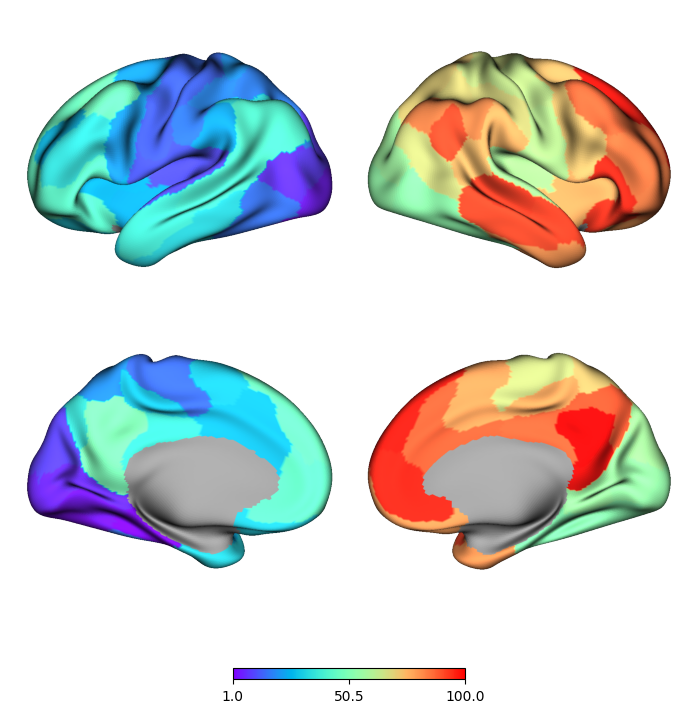

In [33]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

# visualize schaefer atlas into brain surface (each hemisphere contains 32492 voxels)
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']  #inflated, veryinflated, white, pial
# lh, rh = surfaces['veryinflated']  #inflated, veryinflated, white, pial
# lh, rh = surfaces['midthickness']  #inflated, veryinflated, white, pial
p = Plot(lh, rh, views=['lateral', 'medial'], size=(900, 800),  zoom=1.3, layout='grid')

# add schaefer parcellation
lh_parc, rh_parc = load_parcellation('schaefer',scale=100)
print(lh_parc.shape, rh_parc.shape)

p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap = 'rainbow', alpha=1, as_outline=False, cbar=True)

fig = p.build()
fig.show()

In [11]:
# Load the brain atlas labels with additional columns
import pandas as pd

df = pd.read_csv('./data/schaefer_2018/Schaefer2018_100Parcels_17Networks_order_info.txt', sep='\t', header=None)
data = np.array(df)
labels = data[0::2] # extract "roi names, left or right hemisphere, and subnetwork names"
extra_data = np.array([i[0].split(' ') for i in data[1::2]]) # extract "roi id, {x, y, z}, and color info"

badROIs = [9,14,43,60,61,78,89,93] # 8 regions with bad data ("1-based" indexing)

# labels = np.delete(labels, badROIs) # remove the bad ROIs
# extra_data = np.delete(extra_data, badROIs, axis=0) # remove the bad ROIs
# print(labels.shape)
# print(extra_data.shape)

### Note that in schaefer atlas, the region names are not explicitly given:
# e.g., ['LH', 'SomMotA', '2'], there is no explicit region name, only the hemisphere, subnetwork, and parcel index.
split_labels=[]
for label in labels:
    parts = label[0].split('_')[1:]
    if len(parts)==4:
        split_labels.append(parts)
    if len(parts) < 4: # some regions have no name info
        print('Region name is not explicitly given:', label)
        parts.insert(2, 'roi')
        split_labels.append(parts)

df_1 = pd.DataFrame(split_labels, columns=['Hemisphere', 'Subnetwork', 'Region', 'Parcel index'])
df_2 = pd.DataFrame(extra_data, columns=['ROI ID', 'R', 'G', 'B', 'Color'])

# Merge df and df_atlas by extending columns
df_atlas = pd.concat([df_1, df_2], axis=1)
df_atlas.drop([i-1 for i in badROIs], inplace=True)   #drop bad ROIs from the 100 regions.
df_atlas.reset_index(drop=True, inplace=True)
# df_atlas.to_excel('Schaefer2018_92Parcels_17Networks_order_info.xlsx', index=False)
df_atlas

Region name is not explicitly given: ['17Networks_LH_SomMotA_1']
Region name is not explicitly given: ['17Networks_LH_SomMotA_2']
Region name is not explicitly given: ['17Networks_LH_TempPar_1']
Region name is not explicitly given: ['17Networks_RH_SomMotA_1']
Region name is not explicitly given: ['17Networks_RH_SomMotA_2']
Region name is not explicitly given: ['17Networks_RH_SomMotA_3']
Region name is not explicitly given: ['17Networks_RH_SomMotA_4']
Region name is not explicitly given: ['17Networks_RH_TempPar_1']
Region name is not explicitly given: ['17Networks_RH_TempPar_2']
Region name is not explicitly given: ['17Networks_RH_TempPar_3']


Hemisphere Subnetwork    Region Parcel index ROI ID    R   G    B Color
0          LH    VisCent     ExStr            1      1  120  18  136   255
1          LH    VisCent     ExStr            2      2  120  18  137   255
2          LH    VisCent   Striate            1      3  120  18  138   255
3          LH    VisCent     ExStr            3      4  120  18  139   255
4          LH    VisPeri  ExStrInf            1      5  255   0    2   255
..        ...        ...       ...          ...    ...  ...  ..  ...   ...
87         RH   DefaultC       Rsp            1     96    5   0  131   255
88         RH   DefaultC       PHC            1     97    5   0  132   255
89         RH    TempPar       roi            1     98   16  48  255   255
90         RH    TempPar       roi            2     99   13  41  250   255
91         RH    TempPar       roi            3    100   13  41  251   255

[92 rows x 9 columns]

In [12]:
df = df_atlas[['Hemisphere', 'Subnetwork', 'ROI ID']]

roi_by_network_hemisphere = {}

grouped = df.groupby(['Subnetwork', 'Hemisphere'])['ROI ID'].apply(list)

for (subnet, hemi), roi_list in grouped.items():
    if subnet not in roi_by_network_hemisphere:
        roi_by_network_hemisphere[subnet] = {}
    roi_by_network_hemisphere[subnet][hemi] = roi_list

from pprint import pprint
pprint(roi_by_network_hemisphere)


{'ContA': {'LH': ['31', '32', '33'], 'RH': ['80', '81', '82']},
 'ContB': {'LH': ['34'], 'RH': ['83', '84', '85', '86']},
 'ContC': {'LH': ['35', '36', '37'], 'RH': ['87', '88']},
 'DefaultA': {'LH': ['38', '39', '40'], 'RH': ['90', '91', '92']},
 'DefaultB': {'LH': ['41', '42', '44', '45', '46', '47'], 'RH': ['94', '95']},
 'DefaultC': {'LH': ['48', '49'], 'RH': ['96', '97']},
 'DorsAttnA': {'LH': ['15', '16'], 'RH': ['65', '66', '67']},
 'DorsAttnB': {'LH': ['17', '18', '19', '20'], 'RH': ['68', '69', '70']},
 'LimbicA': {'LH': ['29', '30'], 'RH': ['79']},
 'LimbicB': {'LH': ['28']},
 'SalVentAttnA': {'LH': ['21', '22', '23', '24', '25'],
                  'RH': ['71', '72', '73', '74']},
 'SalVentAttnB': {'LH': ['26', '27'], 'RH': ['75', '76', '77']},
 'SomMotA': {'LH': ['8'], 'RH': ['57', '58', '59']},
 'SomMotB': {'LH': ['10', '11', '12', '13'], 'RH': ['62', '63', '64']},
 'TempPar': {'LH': ['50'], 'RH': ['98', '99', '100']},
 'VisCent': {'LH': ['1', '2', '3', '4'], 'RH': ['51', '

### brain modes

In [139]:
temporal_graphs, FC_mats = compute_temporal_graphs(ts_data, subject_idx=2, selected_sessions=selected_sessions, window_size=100, step_size=10)
binary_temporal_graphs = compute_binary_temporal_graphs(FC_mats, threshold=0.4)

In [140]:
print(np.sum(binary_temporal_graphs[70] == 1), np.sum(binary_temporal_graphs[70] == 1))

218 218


#### circle

In [133]:
import numpy as np

def index_to_roi_id(index):
    """
    return corresponding ROI ID
    """
    return int(df_atlas.loc[index, 'ROI ID'])


def get_connected_rois(btg, index):
    """
    return # of all the rois that are connected to other rois
    """
    matrix = btg[index]
    connected_indices = np.argwhere(matrix == 1)
    connected_indices = connected_indices[connected_indices[:, 0] != connected_indices[:, 1]]
    connected_nodes = np.unique(connected_indices)
    connected_node_list = connected_nodes.tolist()
    return connected_node_list

def count_rois_connection(btg, index):
    """
    return the sorted # of degrees of rois
    """
    matrix = btg[index]
    connection_counts = np.sum(matrix, axis=1) 
    sorted_nodes = np.argsort(-connection_counts)
    sorted_node_connections = [(index_to_roi_id(int(node)), int(connection_counts[node])) for node in sorted_nodes]
    return sorted_node_connections

def compute_temporal_new_edges(btg):
    """
    input:
        btg: list of adjacency matrices (binary temporal graphs)

    return:
        new_edges_per_t: dict {time_index: set of new edges}
    """
    seen_edges = set()
    new_edges_per_t = {}

    for t, matrix in enumerate(btg):
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        new_edges = current_edges - seen_edges
        new_edges_roi = {(index_to_roi_id(u), index_to_roi_id(v)) for u, v in new_edges}

        new_edges_per_t[t] = new_edges_roi
        seen_edges.update(current_edges)

    return new_edges_per_t

def compute_temporal_all_edges(btg):
    """
    input:
        btg: list of adjacency matrices (binary temporal graphs)

    return:
        new_edges_per_t: dict {time_index: set of all edges}
    """
    all_edges_per_t = {}

    for t, matrix in enumerate(btg):
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        current_edges_roi = {(index_to_roi_id(u), index_to_roi_id(v)) for u, v in current_edges}

        all_edges_per_t[t] = current_edges_roi

    return all_edges_per_t

def find_roi_location(roi_id, roi_dict):
    """
    output:
        (subnetwork, hemisphere)
    """
    roi_id = str(roi_id) 

    for subnetwork, hemispheres in roi_dict.items():
        for hemisphere, roi_list in hemispheres.items():
            if roi_id in roi_list:
                return subnetwork, hemisphere
    return None

from collections import defaultdict

def extract_active_roi_subnet_structure(new_edges_per_t, roi_dict, time_filter=None):
    """
    input:
        new_edges_per_t: dict[int -> set[(int, int)]]
        roi_dict: dict[subnet -> {hemi -> list[str]}]
        time_filter: int, list[int], or None

    output:
        dict[subnet -> {hemi -> list[str]}]
    """

    if time_filter is None:
        time_points = new_edges_per_t.keys()
    elif isinstance(time_filter, int):
        time_points = [time_filter]
    elif isinstance(time_filter, list):
        time_points = time_filter
    else:
        raise ValueError("time_filter must be int, list[int], or None")

    active_rois = set()
    for t in time_points:
        edge_set = new_edges_per_t.get(t, set())
        for u, v in edge_set:
            active_rois.add(str(u))
            active_rois.add(str(v))

    active_roi_dict = defaultdict(lambda: defaultdict(list))
    for roi_id in active_rois:
        loc = find_roi_location(roi_id, roi_dict)
        if loc:
            subnet, hemi = loc
            active_roi_dict[subnet][hemi].append(roi_id)

    active_roi_dict = {
        subnet: {hemi: sorted(set(rois)) for hemi, rois in hemi_dict.items()}
        for subnet, hemi_dict in active_roi_dict.items()
    }

    return active_roi_dict




In [135]:
new_edges_per_t = compute_temporal_new_edges(binary_temporal_graphs)
print(new_edges_per_t[70])
active_roi_dict_37 = extract_active_roi_subnet_structure(new_edges_per_t, roi_by_network_hemisphere, 70)
print(active_roi_dict_37)
all_edges_per_t = compute_temporal_all_edges(binary_temporal_graphs)
print(len(all_edges_per_t[70]))

{(44, 91)}
{'DefaultB': {'LH': ['44']}, 'DefaultA': {'RH': ['91']}}
51


##### video

/var/folders/wl/7rv_syw512vc9pzdk76485k40000gn/T/ipykernel_1251/3864553709.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(subnet_names))


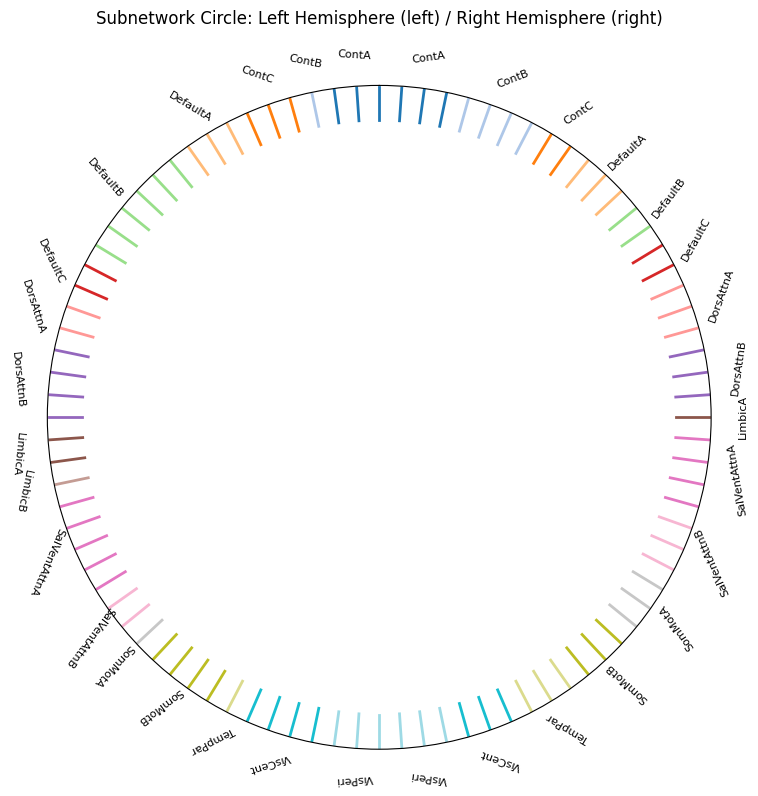

In [123]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import PathPatch
from matplotlib.path import Path
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter


# Flatten and separate ROIs by LH and RH
lh_rois = []
rh_rois = []
rois_index_angles = [0] * 92 # rois_index_angles[0] 1-indexing roi <-> reordered_angles[0] angle
subnet_to_color = {}
subnet_names = list(roi_by_network_hemisphere.keys())
cmap = plt.cm.get_cmap('tab20', len(subnet_names))
for i, subnet in enumerate(subnet_names):
    color = cmap(i)
    for roi in roi_by_network_hemisphere[subnet].get('LH', []):
        lh_rois.append((roi, subnet, color))
        # print(roi, subnet, color)
    for roi in roi_by_network_hemisphere[subnet].get('RH', []):
        rh_rois.append((roi, subnet, color))

# Combine for plotting (LH on left half, RH on right half)
all_rois = lh_rois + rh_rois
n_total = len(all_rois)
# print(n_total) #92
# Compute angles
angles = np.linspace(np.pi, -np.pi, n_total, endpoint=False)


pi_val = angles[0]              # π
positive_half = angles[1:46][::-1]  # reverse: 0.068 → 3.073
zero_val = angles[46]           # 0
negative_half = angles[47:]     # -0.068 → -3.073

reordered_angles = np.concatenate([
    [zero_val],
    negative_half,
    [-pi_val],
    positive_half
])
# print("reordered_angles: ", reordered_angles)

np.set_printoptions(precision=4, suppress=True)

# Plot
# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.set_aspect('equal')

# Plot each ROI as a tick with corresponding subnet color
for i, (roi, subnet, color) in enumerate(all_rois):
    theta = reordered_angles[i]
    ax.plot([theta, theta], [0.9, 1.0], color=color, lw=2)

# Annotate subnet names on each hemisphere
for i, subnet in enumerate(subnet_names):
    # LH label at left half
    lh_indices = [(j, roi) for j, (roi, sn, _) in enumerate(lh_rois) if sn == subnet]
    lj_indices = [j for j, _ in lh_indices]
    roi_indices = [r for _, r in lh_indices]
    if lj_indices:
        theta_lh = np.mean([reordered_angles[j] for j in lj_indices])
        ax.text(theta_lh, 1.1, subnet, ha='center', va='center', fontsize=8, rotation=np.rad2deg(theta_lh), rotation_mode='anchor')
    if roi_indices:
        for ii, j in enumerate(lj_indices):
            rois_index_angles[j] = roi_indices[ii]

    # RH label at right half
    rh_indices = [(j + len(lh_rois), roi) for j, (roi, sn, _) in enumerate(rh_rois) if sn == subnet]
    rj_indices = [j for j, _ in rh_indices]
    roi_indices = [r for _, r in rh_indices]
    if rj_indices:
        theta_rh = np.mean([reordered_angles[j] for j in rj_indices])
        ax.text(theta_rh, 1.1, subnet, ha='center', va='center', fontsize=8, rotation=np.rad2deg(theta_rh), rotation_mode='anchor')
    if roi_indices:
        for ii, j in enumerate(rj_indices):
            rois_index_angles[j] = roi_indices[ii]

# print("rois_index_angles: ", rois_index_angles)

time_idx = 40
edges = list(new_edges_per_t[time_idx])  # all edges for time 2

# for u, v in edges:
#     th1 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == u)].item()
#     th2 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == v)].item()
#     ax.plot([th1, th2], [0.85, 0.85], color='blue', lw=1.5, alpha=0.5)

#     ax.plot([th1], [0.85], 'ro')
#     ax.plot([th2], [0.85], 'ro')
line_collection = []
time_text = None

def update(frame):
    global line_collection, time_text
    for line in line_collection:
        line.remove()
    line_collection = []
    if time_text is not None:
        time_text.remove()
    
    edges = new_edges_per_t.get(frame, set())
    for u, v in edges:
        th1 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == u)].item()
        th2 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == v)].item()
        line, = ax.plot([th1, th2], [0.85, 0.85], color='blue', lw=1.5, alpha=0.6)
        line_collection.append(line)

    time_text = ax.text(0, 0.5, f"Time: {frame}", ha='center', va='center',
                        fontsize=18, color='black', bbox=dict(facecolor='white', edgecolor='black'))


plt.title("Subnetwork Circle: Left Hemisphere (left) / Right Hemisphere (right)", y=1.08)
plt.tight_layout()
plt.show()

ani = FuncAnimation(fig, update, frames=len(new_edges_per_t), interval=800, repeat=True)
# ani.save("brain_connections.gif", writer='pillow', fps=1)
writer = FFMpegWriter(fps=1)
ani.save("brain_connections.mp4", writer=writer)


##### photo

/var/folders/wl/7rv_syw512vc9pzdk76485k40000gn/T/ipykernel_1251/2118426029.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(subnet_names))


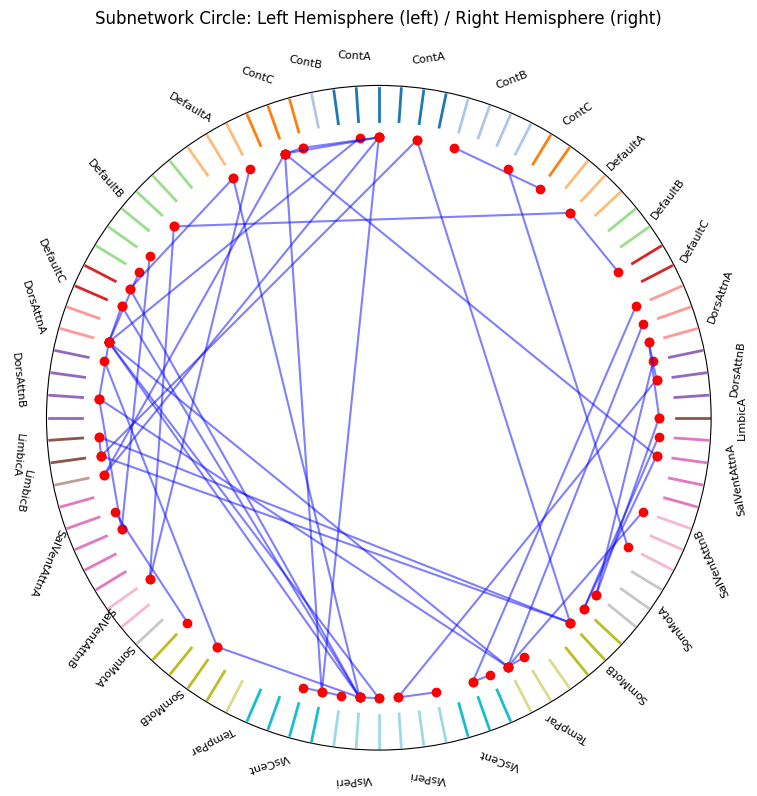

In [138]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import PathPatch
from matplotlib.path import Path
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter


# Flatten and separate ROIs by LH and RH
lh_rois = []
rh_rois = []
rois_index_angles = [0] * 92 # rois_index_angles[0] 1-indexing roi <-> reordered_angles[0] angle
subnet_to_color = {}
subnet_names = list(roi_by_network_hemisphere.keys())
cmap = plt.cm.get_cmap('tab20', len(subnet_names))
for i, subnet in enumerate(subnet_names):
    color = cmap(i)
    for roi in roi_by_network_hemisphere[subnet].get('LH', []):
        lh_rois.append((roi, subnet, color))
        # print(roi, subnet, color)
    for roi in roi_by_network_hemisphere[subnet].get('RH', []):
        rh_rois.append((roi, subnet, color))

# Combine for plotting (LH on left half, RH on right half)
all_rois = lh_rois + rh_rois
n_total = len(all_rois)
# print(n_total) #92
# Compute angles
angles = np.linspace(np.pi, -np.pi, n_total, endpoint=False)


pi_val = angles[0]              # π
positive_half = angles[1:46][::-1]  # reverse: 0.068 → 3.073
zero_val = angles[46]           # 0
negative_half = angles[47:]     # -0.068 → -3.073

reordered_angles = np.concatenate([
    [zero_val],
    negative_half,
    [-pi_val],
    positive_half
])
# print("reordered_angles: ", reordered_angles)

np.set_printoptions(precision=4, suppress=True)

# Plot
# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.set_aspect('equal')

# Plot each ROI as a tick with corresponding subnet color
for i, (roi, subnet, color) in enumerate(all_rois):
    theta = reordered_angles[i]
    ax.plot([theta, theta], [0.9, 1.0], color=color, lw=2)

# Annotate subnet names on each hemisphere
for i, subnet in enumerate(subnet_names):
    # LH label at left half
    lh_indices = [(j, roi) for j, (roi, sn, _) in enumerate(lh_rois) if sn == subnet]
    lj_indices = [j for j, _ in lh_indices]
    roi_indices = [r for _, r in lh_indices]
    if lj_indices:
        theta_lh = np.mean([reordered_angles[j] for j in lj_indices])
        ax.text(theta_lh, 1.1, subnet, ha='center', va='center', fontsize=8, rotation=np.rad2deg(theta_lh), rotation_mode='anchor')
    if roi_indices:
        for ii, j in enumerate(lj_indices):
            rois_index_angles[j] = roi_indices[ii]

    # RH label at right half
    rh_indices = [(j + len(lh_rois), roi) for j, (roi, sn, _) in enumerate(rh_rois) if sn == subnet]
    rj_indices = [j for j, _ in rh_indices]
    roi_indices = [r for _, r in rh_indices]
    if rj_indices:
        theta_rh = np.mean([reordered_angles[j] for j in rj_indices])
        ax.text(theta_rh, 1.1, subnet, ha='center', va='center', fontsize=8, rotation=np.rad2deg(theta_rh), rotation_mode='anchor')
    if roi_indices:
        for ii, j in enumerate(rj_indices):
            rois_index_angles[j] = roi_indices[ii]

# print("rois_index_angles: ", rois_index_angles)

time_idx = 70
edges = list(all_edges_per_t[time_idx])  # all edges for time 2

for u, v in edges:
    th1 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == u)].item()
    th2 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == v)].item()
    ax.plot([th1, th2], [0.85, 0.85], color='blue', lw=1.5, alpha=0.5)

    ax.plot([th1], [0.85], 'ro')
    ax.plot([th2], [0.85], 'ro')
# line_collection = []
# time_text = None

# def update(frame):
#     global line_collection, time_text
#     for line in line_collection:
#         line.remove()
#     line_collection = []
#     if time_text is not None:
#         time_text.remove()
    
#     edges = new_edges_per_t.get(frame, set())
#     for u, v in edges:
#         th1 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == u)].item()
#         th2 = reordered_angles[np.argwhere(np.array(rois_index_angles).astype(int) == v)].item()
#         line, = ax.plot([th1, th2], [0.85, 0.85], color='blue', lw=1.5, alpha=0.6)
#         line_collection.append(line)

#     time_text = ax.text(0, 0.5, f"Time: {frame}", ha='center', va='center',
#                         fontsize=18, color='black', bbox=dict(facecolor='white', edgecolor='black'))


plt.title("Subnetwork Circle: Left Hemisphere (left) / Right Hemisphere (right)", y=1.08)
plt.tight_layout()
plt.savefig("figure.png", dpi=300, bbox_inches='tight')
plt.show()



# ani = FuncAnimation(fig, update, frames=len(new_edges_per_t), interval=800, repeat=True)
# # ani.save("brain_connections.gif", writer='pillow', fps=1)
# writer = FFMpegWriter(fps=1)
# ani.save("brain_connections.mp4", writer=writer)


In [141]:
print(len(get_connected_rois(binary_temporal_graphs, 39)), len(get_connected_rois(binary_temporal_graphs, 38)))

72 70


In [159]:
for node, count in count_rois_connection(binary_temporal_graphs, 39)[:10]:
        print(f"Node {node} has {count} connections")
for node, count in count_rois_connection(binary_temporal_graphs, 38)[:10]:
        print(f"Node {node} has {count} connections")


Node 19 has 19 connections
Node 100 has 14 connections
Node 36 has 14 connections
Node 68 has 14 connections
Node 35 has 12 connections
Node 51 has 11 connections
Node 29 has 11 connections
Node 67 has 11 connections
Node 72 has 11 connections
Node 69 has 11 connections
Node 58 has 11 connections
Node 72 has 10 connections
Node 94 has 9 connections
Node 57 has 8 connections
Node 35 has 8 connections
Node 44 has 8 connections
Node 41 has 7 connections
Node 29 has 7 connections
Node 69 has 7 connections
Node 67 has 7 connections


#### regions

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from nilearn import datasets, image

def plot_max_projection_from_connections(sorted_node_connections, vmax=None, cmap='plasma'):

    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=17, resolution_mm=2, data_dir='data')
    atlas_img = image.load_img(atlas['maps'])
    atlas_data = atlas_img.get_fdata() # (91, 109, 91)

    voxel_coords = np.argwhere(atlas_data > 0) # (132032, 3)
    affine = atlas_img.affine


    weighted_mask = np.zeros_like(atlas_data) # (91, 109, 91)
    if vmax is None:
        vmax = max(conn for _, conn in sorted_node_connections)

    for node_index, conn in sorted_node_connections:
        roi_label = node_index + 1  
        weighted_mask[atlas_data == roi_label] = conn
 
    # z_indices = np.argmax(weighted_mask, axis=2)
    # x_dim, y_dim = z_indices.shape
    # voxel_coords = [(x, y, z_indices[x, y]) for x in range(x_dim) for y in range(y_dim)]
    # mni_coords = [atlas_img.affine @ [x, y, z, 1] for x, y, z in voxel_coords]
    # mni_coords = np.array([coord[:3] for coord in mni_coords]) 
    # print(mni_coords[:, :2])

    max_proj = np.max(weighted_mask, axis=2) # (91, 109)
    # mni_coords = [affine @ [x, y, z, 1] for x, y, z in max_proj]
    # mni_coords = np.array([coord[:3] for coord in mni_coords])  

    plasma = plt.cm.inferno
    new_cmap = plasma(np.linspace(0, 1, 256))
    new_cmap[0] = [1,1,1,1]  
    custom_cmap = colors.ListedColormap(new_cmap)

    plt.figure(figsize=(6, 6), facecolor='white')
    plt.imshow(np.rot90(max_proj), cmap=custom_cmap, vmin=0, vmax=19)
    plt.title("Max Z Projection of ROI Connection Counts")
    plt.axis('off')
    plt.colorbar(label='Connection Count')
    plt.show()


[get_dataset_dir] Dataset found in data/schaefer_2018

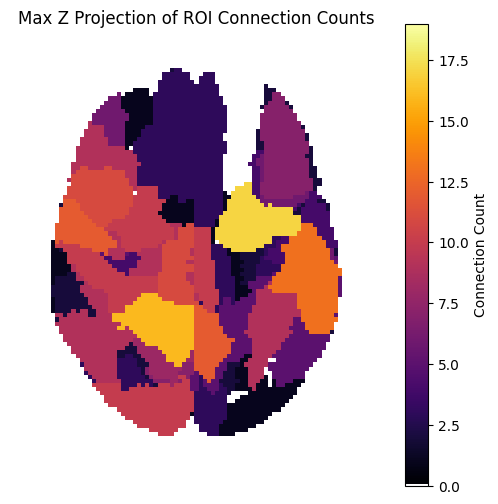

In [163]:
sorted_node_connections = count_rois_connection(binary_temporal_graphs, 40)
plot_max_projection_from_connections(sorted_node_connections)

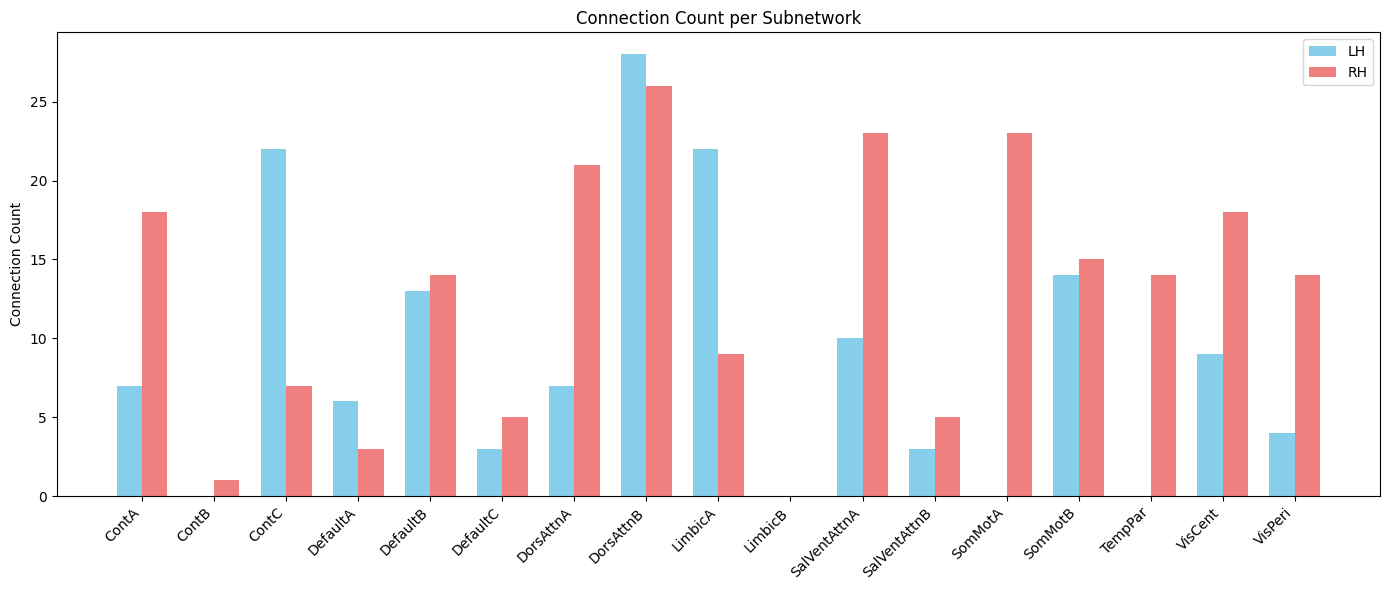

In [157]:
# Re-import necessary libraries after kernel reset
import matplotlib.pyplot as plt
from collections import defaultdict


# Aggregate connection counts per (subnetwork, hemisphere)
subnet_hemisphere_counts = defaultdict(int)
for roi_id, conn_count in sorted_node_connections:
    subnet, hemi = find_roi_location(roi_id, roi_by_network_hemisphere)
    key = f"{subnet}-{hemi}"
    subnet_hemisphere_counts[key] += conn_count


subnet_groups = defaultdict(lambda: [0, 0])
for key, value in subnet_hemisphere_counts.items():
    subnet, hemi = key.split("-")
    if hemi == "LH":
        subnet_groups[subnet][0] = value
    elif hemi == "RH":
        subnet_groups[subnet][1] = value

sorted_subnets = sorted(subnet_groups.keys())

x = list(range(len(sorted_subnets)))
bar_width = 0.35

lh_counts = [subnet_groups[subnet][0] for subnet in sorted_subnets]
rh_counts = [subnet_groups[subnet][1] for subnet in sorted_subnets]


plt.figure(figsize=(14, 6))
plt.bar([i - bar_width/2 for i in x], lh_counts, width=bar_width, label='LH', color='skyblue')
plt.bar([i + bar_width/2 for i in x], rh_counts, width=bar_width, label='RH', color='lightcoral')

plt.xticks(x, sorted_subnets, rotation=45, ha='right')
plt.ylabel("Connection Count")
plt.title("Connection Count per Subnetwork")
plt.legend()
plt.tight_layout()
plt.show()

(91, 109, 91)
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
(91, 109, 91)
range from  48 to  65
all # of cuts 18
mni:
range from  24.0 to  58.0
all # of cuts 18


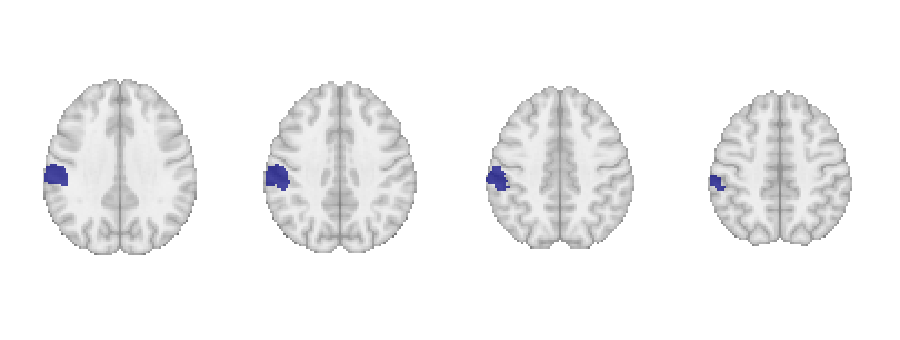

In [189]:
from nilearn import image

img = image.load_img('./data/schaefer_2018/Schaefer2018_100Parcels_17Networks_order_FSLMNI152_2mm.nii.gz')
# Print basic info
print(img.shape)        # 3D or 4D shape
print(img.affine)       # affine transformation matrix

# Convert to numpy array
data = img.get_fdata()
print(data.shape)       # same shape as img.shape

# Choose an ROI label (e.g., 60)
roi_label = 17
# print(np.argwhere(data == roi_label).shape) # (1590, 3)

coords = np.argwhere(data == roi_label)
z_vals = coords[:, 2]          
print("range from ", z_vals.min(), "to ", z_vals.max()) 
print("all # of cuts", len(np.unique(z_vals)))

affine = atlas_img.affine
mni_coords = [affine @ [x, y, z, 1] for x, y, z in coords]
mni_coords = [tuple(coord[:3]) for coord in mni_coords] 
z_vals_mni = np.array(mni_coords)[:, 2]
print("mni:")
print("range from ", z_vals_mni.min(), "to ",z_vals_mni.max()) 
print("all # of cuts", len(np.unique(z_vals_mni)))

# Create a binary mask for this ROI
roi_mask = image.math_img("img == %d" % roi_label, img=img)
# Plot the ROI
plotting.plot_roi(roi_mask, 
                  title=None,   
                  display_mode='z',
                  cut_coords=[34,38,45,48],
                  annotate=False  )
plotting.show()

#### centroid

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, image

def plot_roi_centers_from_connections(sorted_node_connections, vmax=None, cmap='inferno'):
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=17, resolution_mm=2, data_dir='data')
    atlas_img = image.load_img(atlas['maps'])
    atlas_data = atlas_img.get_fdata()

    if vmax is None:
        vmax = max(conn for _, conn in sorted_node_connections)

    centers = []
    values = []

    for node_index, conn in sorted_node_connections:
        roi_label = node_index + 1
        coords = np.argwhere(atlas_data == roi_label)
        # affine = atlas_img.affine
        # mni_coords = [affine @ [x, y, z, 1] for x, y, z in coords]
        # mni_coords = np.array([tuple(coord[:3]) for coord in mni_coords])

        # print("coods: ", coords)
        if len(coords) > 0:
            center_voxel = coords.mean(axis=0)  # [x, y, z]
            # print("center:", center_voxel)
            centers.append(center_voxel)
            values.append(conn)

    centers = np.array(centers)
    values = np.array(values)

    brain_mask = (atlas_data > 0).astype(float)
    max_proj = np.max(brain_mask, axis=2)
    # print(max_proj.shape)

    # Prepare canvas
    plt.figure(figsize=(6, 6), facecolor='white')
    plt.imshow(np.rot90(max_proj), cmap='gray', alpha=0.2)

    # # Align scatter with rotated image
    # scatter_x = centers[:, 1]  # y axis becomes x
    # scatter_y = atlas_data.shape[0] - centers[:, 0]  # x axis becomes y and reversed

    sc = plt.scatter(
        centers[:, 0],
        max_proj.shape[1] - centers[:, 1],
        c=values,
        cmap=cmap,
        s=100,
        edgecolors='black',
        linewidth=0.6,
        vmin=0,
        vmax=vmax
    )

    plt.title("ROI Centers Colored by Connection Count")
    # plt.gca().invert_xaxis()
    plt.axis('off')
    plt.colorbar(sc, label='Connection Count')
    plt.show()


[get_dataset_dir] Dataset found in data/schaefer_2018

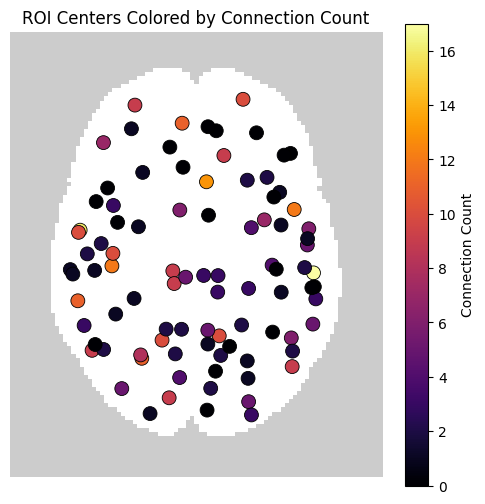

In [261]:
sorted_node_connections = count_rois_connection(binary_temporal_graphs, 40)
plot_roi_centers_from_connections(sorted_node_connections)

#### outer brain in circle

[get_dataset_dir] Dataset found in data/schaefer_2018

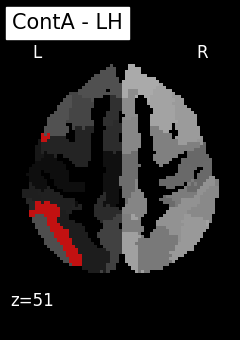

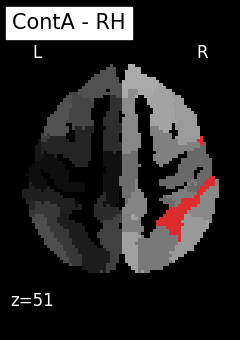

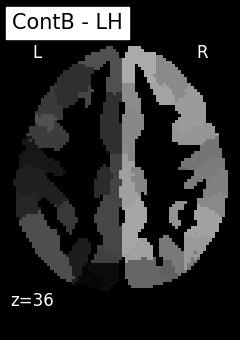

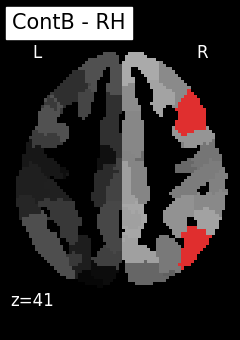

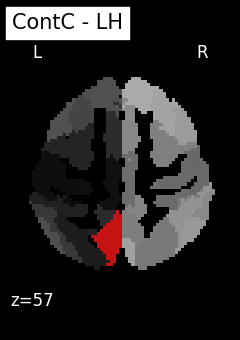

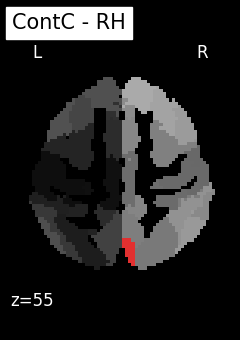

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, datasets, image
from nilearn.image import new_img_like

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=17, resolution_mm=2, data_dir='data')
atlas_img = image.load_img(atlas['maps'])
atlas_data = atlas_img.get_fdata()

roi_dict = {
    'ContA': {'LH': ['31', '32', '33'], 'RH': ['80', '81', '82']},
    'ContB': {'LH': ['34'], 'RH': ['83', '84', '85', '86']},
    'ContC': {'LH': ['35', '36', '37'], 'RH': ['87', '88']}
}

for network, hemi_dict in roi_dict.items():
    for hemi in ['LH', 'RH']:
        roi_ids = hemi_dict.get(hemi, [])
        if not roi_ids:
            continue

        overlay_data = np.zeros_like(atlas_data)
        for roi_id in roi_ids:
            overlay_data[atlas_data == int(roi_id)] = 1

        overlay_img = new_img_like(atlas_img, overlay_data)

        z_nonzero = np.argwhere(np.any(np.any(overlay_data, axis=0), axis=0))
        if z_nonzero.size > 0:
            z_cut = int(np.median(z_nonzero))
        else:
            z_cut = 0

        # plot z 轴视图
        display = plotting.plot_roi(
            overlay_img,
            bg_img=atlas_img,
            display_mode='z',
            cut_coords=[z_cut],
            title=f'{network} - {hemi}',
            cmap='autumn', 
            colorbar=False
        )
        plotting.show()


## cosine similarity

### weighted

In [298]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns

def cosine_sim_plot(graph_type):
    # Set Seaborn style for better aesthetics
    
    sns.set_style("whitegrid")

    cosine_similarities = []
    reference_time_step = 10

    # Iterate over time steps starting from time step 9 to num_windows_per_session - 1
    for t in range(reference_time_step - 1, len(graph_type) - 1):
        # Compute the cosine similarity between the adjacency matrix at time step t and the adjacency matrices of its past 10 time steps
        cosine_sim_values = []
        for i in range(reference_time_step):
            if np.sum(graph_type[t]) == 0 or np.sum(graph_type[t - i]) == 0:
                cosine_sim = 1.0  
            else:
                cosine_sim = cosine_similarity(graph_type[t], graph_type[t - i])
            cosine_sim_values.append(cosine_sim[0, 0])
        # print("t = ", cosine_sim_values)
        cosine_similarities.append(cosine_sim_values)

    # Compute the average similarity across all time points
    average_similarity = np.mean(cosine_similarities, axis=0)


    # Define a smooth color palette for better visualization
    colors = sns.color_palette("coolwarm", len(cosine_similarities))

    # Plotting
    plt.figure(figsize=(10, 6))
    for i, (y_values, color) in enumerate(zip(cosine_similarities, colors)):
        x_values = range(0, -reference_time_step, -1)  # Adjust x-axis range
        plt.plot(x_values, y_values, linestyle='-', linewidth=1.5, color=color)  # Reduced linewidth

    # Plot the average similarity line in black
    plt.plot(x_values, average_similarity, linestyle='-', linewidth=2, color='black', label='Average Similarity')

    plt.xlabel('Past Time Steps', fontsize=14)
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.title('Temporal Dynamics of Cosine Similarity for weighted graph', fontsize=16)
    plt.ylim(0, 1)
    plt.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
    plt.show()

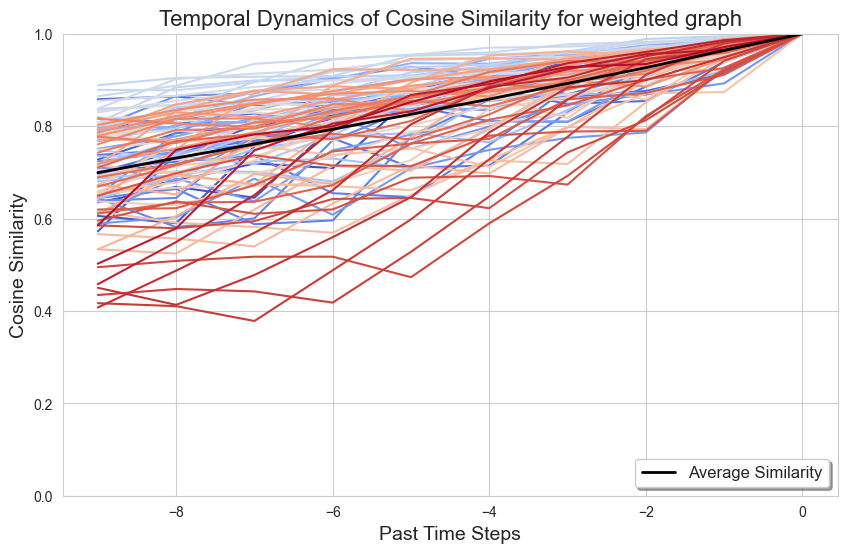

In [299]:
cosine_sim_plot(weighted_graph)

### binary

In [306]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns

def cosine_sim_binary_plot(graph_types, thresholds):
    # Set Seaborn style for better aesthetics
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (graph_type, threshold) in enumerate(zip(graph_types, thresholds)):
        row, col = divmod(idx, 2)
        ax = axes[row, col]
        
        cosine_similarities = []
        reference_time_step = 10

        # Iterate over time steps starting from time step 9 to num_windows_per_session - 1
        for t in range(reference_time_step - 1, len(graph_type)):
            cosine_sim_values = []
            for i in range(reference_time_step):
                cosine_sim = cosine_similarity(graph_type[t].flatten().reshape(1, -1), graph_type[t - i].flatten().reshape(1, -1))
                cosine_sim_values.append(cosine_sim[0, 0])

            cosine_similarities.append(cosine_sim_values)

        # Compute the average similarity across all time points
        average_similarity = np.mean(cosine_similarities, axis=0)

        # Define a smooth color palette for better visualization
        colors = sns.color_palette("coolwarm", len(cosine_similarities))

        # Plot each similarity trajectory
        for y_values, color in zip(cosine_similarities, colors):
            x_values = range(0, -reference_time_step, -1)
            ax.plot(x_values, y_values, linestyle='-', linewidth=1.2, color=color)  # Finer linewidth
        
        # Plot the average similarity line in black
        ax.plot(x_values, average_similarity, linestyle='-', linewidth=1.5, color='black', label='Average Similarity')
        
        ax.set_xlabel('Past Time Steps', fontsize=12)
        ax.set_ylabel('Cosine Similarity', fontsize=12)
        ax.set_title(f'Threshold: {threshold}', fontsize=14)
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle='-', alpha=0.6)
        ax.legend(fontsize=12, loc='lower right', frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.show()

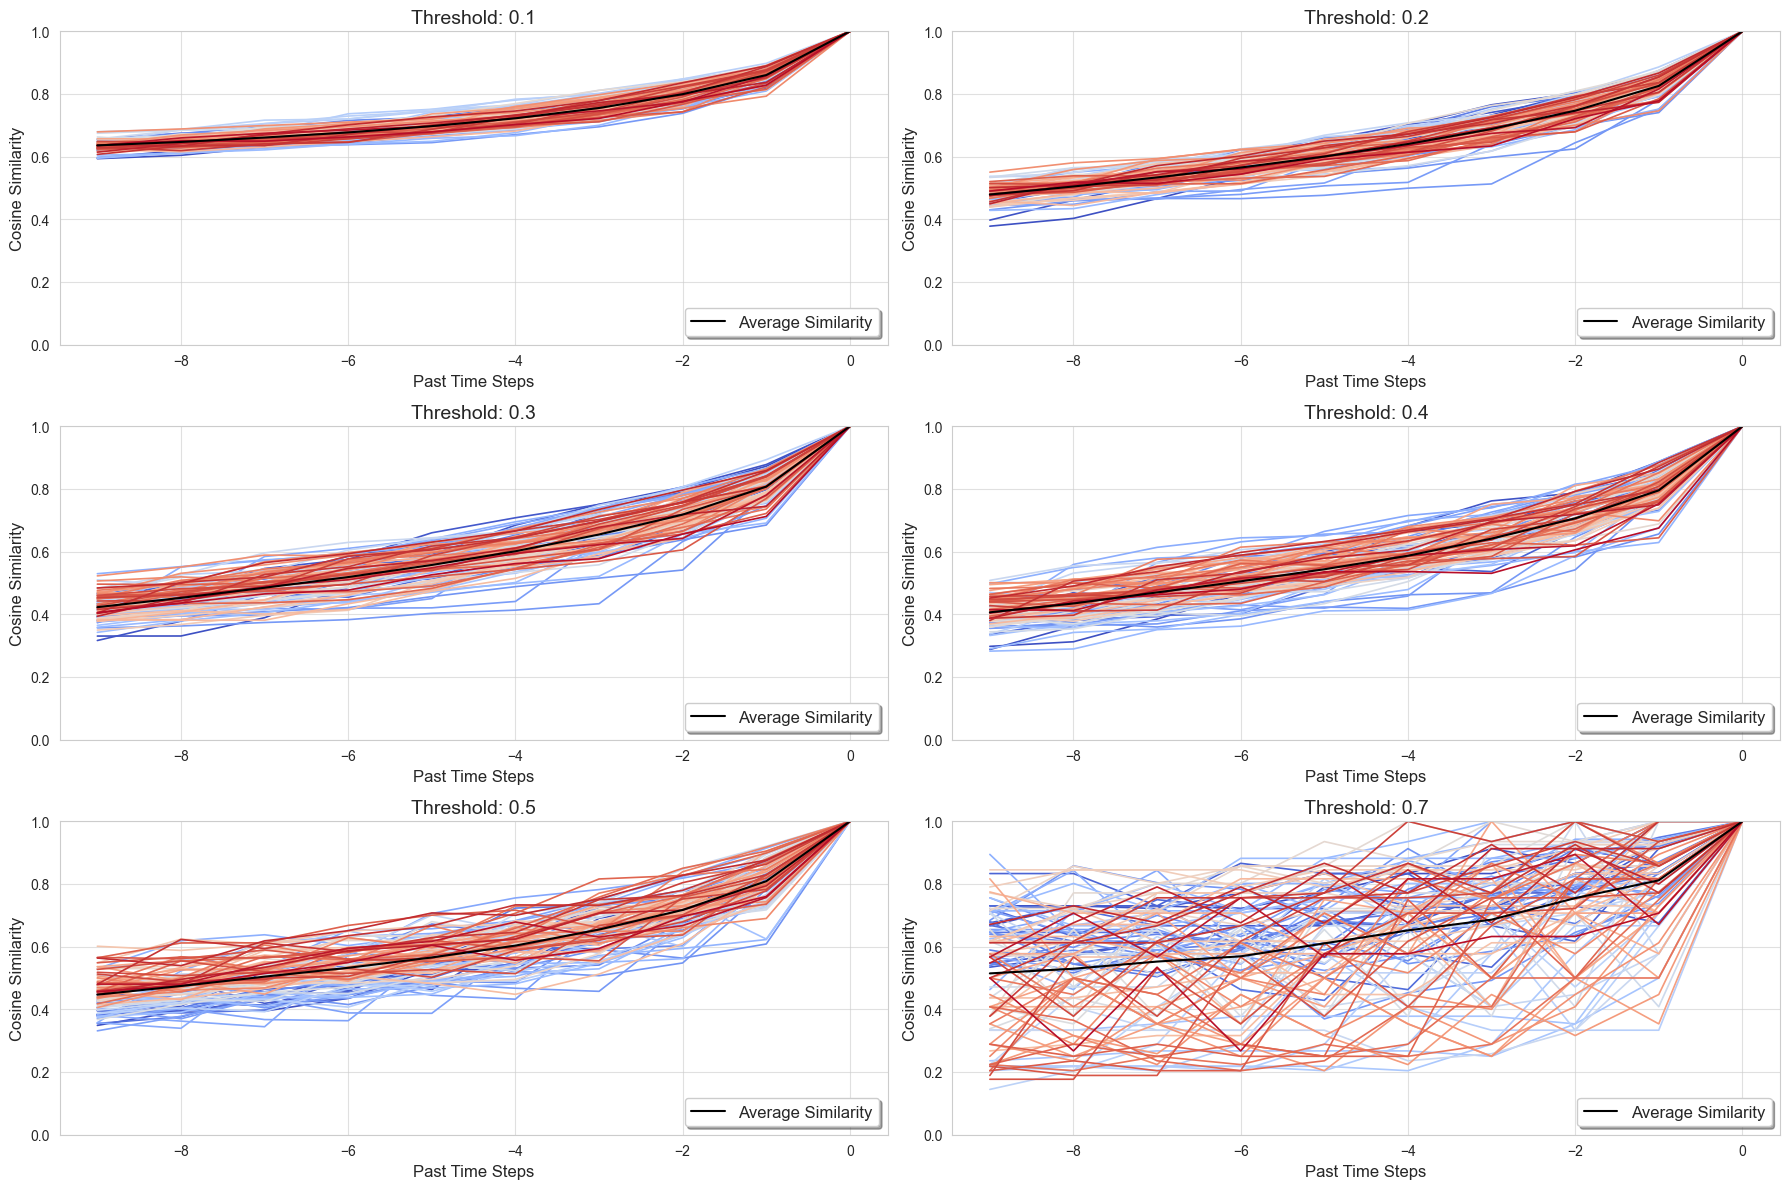

In [ ]:
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
cosine_sim_binary_plot(binary_temporal_graphs_list, thresh_list)

# prepare data

In [57]:
# Prepare data function
import itertools

def prepare_data_adaptive(dynfc_matrices, adaptive_lookbacks):
    dataset = {}
    hop_dict = {}
    scale_terms_dict = {}
    triplet_dict = {}
    scale_dict = {}

    num_windows, num_nodes, _ = dynfc_matrices.shape

    for i in range(len(adaptive_lookbacks)):
        lookback = adaptive_lookbacks[i]
        if i < lookback:
            continue  

        B = np.zeros((num_nodes, lookback + 1, num_nodes))
        for j in range(lookback + 1):
            B[:, j, :] = dynfc_matrices[i - lookback + j]
        dataset[i] = B

        hops = get_hops(dynfc_matrices[i], lookback)
        scale_terms = {
            h if h != -1 else max(hops.keys()) + 1:
            hops[h].sum(1) if h != -1 else hops[1].shape[0] - hops[h].sum(1)
            for h in hops
        }

        hop_dict[i] = hops
        scale_terms_dict[i] = scale_terms

        triplet, scale = to_triplets(sample_all_hops(hop_dict[i]), scale_terms_dict[i])
        triplet_dict[i] = triplet
        scale_dict[i] = scale

    return dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict


def prepare_data(dynfc_matrices, lookback):
    dataset = {}
    hop_dict = {}
    scale_terms_dict = {}
    triplet_dict = {}
    scale_dict = {}

    num_windows, num_nodes, _ = dynfc_matrices.shape

    for i in range(lookback, num_windows):
        B = np.zeros((num_nodes, lookback + 1, num_nodes))
        for j in range(lookback + 1):
            adj_matr = dynfc_matrices[i - lookback + j]
            B[:, j, :] = adj_matr
        dataset[i] = B

    for i in range(lookback, num_windows):
        hops = get_hops(dynfc_matrices[i], 2) #!!!!
        scale_terms = {h if h != -1 else max(hops.keys()) + 1:
                       hops[h].sum(1) if h != -1 else hops[1].shape[0] - hops[h].sum(1)
                       for h in hops}
    

        hop_dict[i] = hops
        scale_terms_dict[i] = scale_terms

        triplet, scale = to_triplets(sample_all_hops(hop_dict[i]), scale_terms_dict[i])
        triplet_dict[i] = triplet
        scale_dict[i] = scale

    return dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict

# Define function to sample last hop
def sample_last_hop(dynfc_matrices, nodes):
    num_windows, num_nodes, _ = dynfc_matrices.shape
    sampled = np.random.randint(0, num_nodes, len(nodes))
    for window_idx in range(num_windows):
        window_matrix = dynfc_matrices[window_idx]
        nnz = np.nonzero(window_matrix[nodes, sampled])[0]
        while len(nnz) != 0:
            new_sample = np.random.randint(0, num_nodes, len(nnz))
            sampled[nnz] = new_sample
            nnz = np.nonzero(window_matrix[nnz, new_sample])[0]
    return sampled

# Define function to sample all hops
def sample_all_hops(hops, nodes=None):
    N = hops[1].shape[0]
    if nodes is None:
        nodes = np.arange(N)
    sampled_nodes = []
    for node in nodes:
        node_samples = [node]
        for h in hops.keys():
            if h != -1:
                if len(hops[h]) == 0:
                    node_samples.append(-1)
                else:
                    node_samples.append(np.random.choice(hops[h][node]))
        node_samples.append(np.random.randint(0, N))
        sampled_nodes.append(node_samples)
    return np.array(sampled_nodes)

# Define function to get hops
def get_hops(dynfc_matrices, K=2):
    num_windows, num_nodes = dynfc_matrices.shape
    hops = {1: dynfc_matrices.copy(), -1: dynfc_matrices.copy()}
    np.fill_diagonal(hops[1], 0)
    for h in range(2, K + 1):
        next_hop = np.dot(hops[h - 1], dynfc_matrices)
        next_hop[next_hop > 0] = 1
        for prev_h in range(1, h):
            next_hop -= np.multiply(next_hop, hops[prev_h])
        np.fill_diagonal(next_hop, 0)
        hops[h] = next_hop
        hops[-1] += next_hop
    return hops

# Define function to convert to triplets
def to_triplets(sampled_nodes, scale_terms):
    triplets = []
    triplet_scale_terms = []
    for i, j in itertools.combinations(np.arange(1, sampled_nodes.shape[1]), 2):
        triplet = sampled_nodes[:, [0] + [i, j]]
        triplet = triplet[(triplet[:, 1] != -1) & (triplet[:, 2] != -1)]
        triplet = triplet[(triplet[:, 0] != triplet[:, 1]) & (triplet[:, 0] != triplet[:, 2])]
        triplets.append(triplet)
        triplet_scale_terms.append(scale_terms[i][triplet[:, 1]] * scale_terms[j][triplet[:, 2]])
    return np.row_stack(triplets), np.concatenate(triplet_scale_terms)


In [27]:
# Define hyperparameters
import torch


dim_out = 64
dim_in  = 92
dim_val = 256
dim_attn = 256
lr = 2.2307858381535968e-05
n_heads = 1
n_encoder_layers = 1
lookback = 2
epochs = 245
dropout=0.1766
weight_decay=1.466563344626497e-05

original_data = binary_temporal_graphs  # shape (111, 92, 92)
# padded_data = np.zeros((111, 96, 96), dtype=original_data.dtype)
# padded_data[:, :92, :92] = original_data

# Prepare data
dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict = prepare_data(original_data, lookback)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_size = int(0.7 * binary_temporal_graphs_len)  # 77 samples for training
val_size = int(0.2 * binary_temporal_graphs_len)  # 22 samples for validation
test_size = binary_temporal_graphs_len - train_size - val_size  # 12 samples for testing
train_val_gap_size = 0  # No gap needed

# Compute new indices
train_end = lookback + train_size
val_start = train_end
val_end = val_start + val_size
test_start = val_end
test_end = binary_temporal_graphs_len

# Define training, validation, and test datasets
train_data = {i: torch.tensor(dataset[i], dtype=torch.float32).to(device) for i in range(lookback, train_end)}
val_data = {i: torch.tensor(dataset[i], dtype=torch.float32).to(device) for i in range(val_start, val_end)}
test_data = {i: torch.tensor(dataset[i], dtype=torch.float32).to(device) for i in range(test_start, test_end)}

# Print confirmation
print(f"Training Data: {lookback} to {train_end}")
print(f"Validation Data: {val_start} to {val_end}")
print(f"Test Data: {test_start} to {test_end}")

Training Data: 2 to 79
Validation Data: 79 to 101
Test Data: 101 to 111


In [58]:
dataset, hop_dict, scale_terms_dict, triplet_dict, scale_dict = prepare_data_adaptive(original_data, adaptive_lookbacks)

In [59]:
len(dataset), len(hop_dict), len(scale_terms_dict), len(triplet_dict), len(scale_dict)

(106, 106, 106, 106, 106)

In [68]:
dataset[32].shape

(92, 5, 92)

# Intrinsic Dimensionality Analysis

In [9]:
temporal_graphs, FC_mats = compute_temporal_graphs(ts_data, subject_idx=2, selected_sessions=selected_sessions, window_size=100, step_size=10)
binary_temporal_graphs = compute_binary_temporal_graphs(FC_mats, threshold=0.4)
weighted_graph = np.transpose(FC_mats,(2, 0, 1))

## PCA

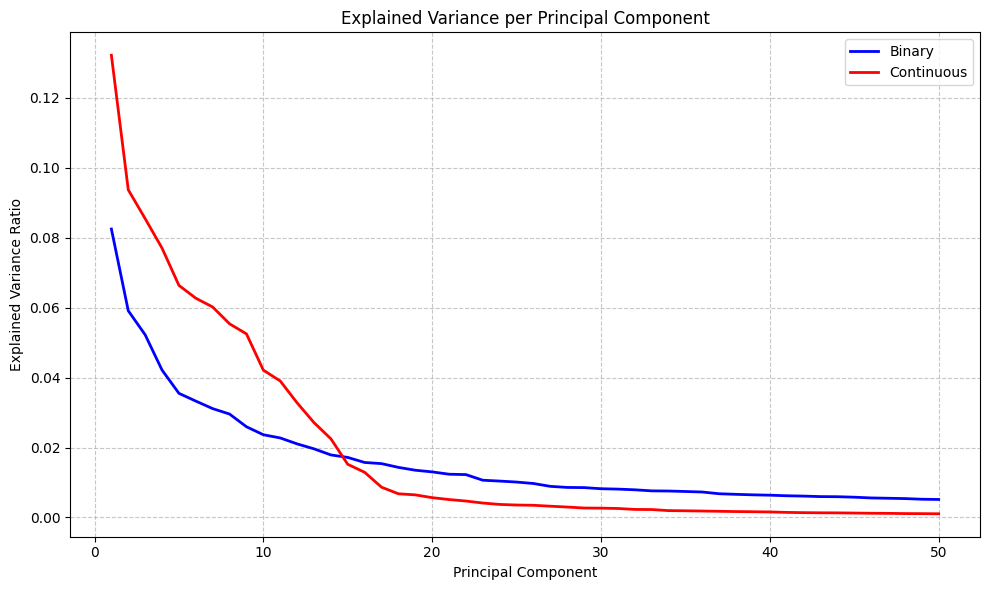

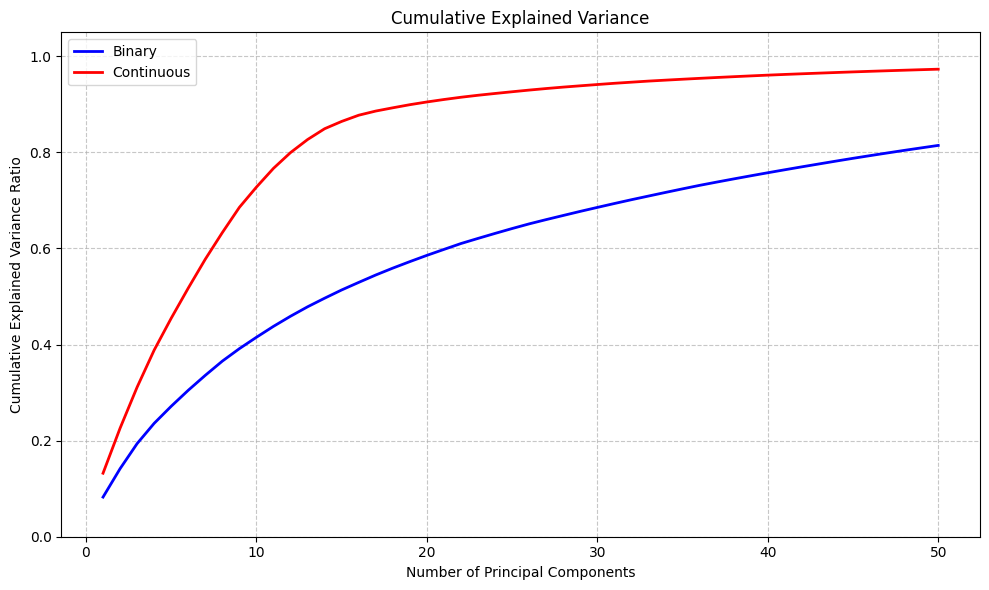

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: binary_temporal_graphs
X_bin = binary_temporal_graphs.reshape(111, -1)
scaler_bin = StandardScaler()
X_bin_scaled = scaler_bin.fit_transform(X_bin)

pca_bin = PCA(n_components=50)
X_bin_pca = pca_bin.fit_transform(X_bin_scaled)

explained_variance_ratio_bin = pca_bin.explained_variance_ratio_
cumulative_explained_variance_bin = np.cumsum(explained_variance_ratio_bin)

# Step 2: temporal_graphs
X_temp = np.array(weighted_graph).reshape(111, -1)
scaler_temp = StandardScaler()
X_temp_scaled = scaler_temp.fit_transform(X_temp)

pca_temp = PCA(n_components=50)
X_temp_pca = pca_temp.fit_transform(X_temp_scaled)

explained_variance_ratio_temp = pca_temp.explained_variance_ratio_
cumulative_explained_variance_temp = np.cumsum(explained_variance_ratio_temp)

# Step 3: Plot explained variance per component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_bin) + 1), explained_variance_ratio_bin,
         color='blue', label='Binary', linewidth=2)
plt.plot(range(1, len(explained_variance_ratio_temp) + 1), explained_variance_ratio_temp,
         color='red', label='Continuous', linewidth=2)
plt.title('Explained Variance per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_bin) + 1), cumulative_explained_variance_bin,
         color='blue', label='Binary', linewidth=2)
plt.plot(range(1, len(cumulative_explained_variance_temp) + 1), cumulative_explained_variance_temp,
         color='red', label='Continuous', linewidth=2)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


(111, 5)


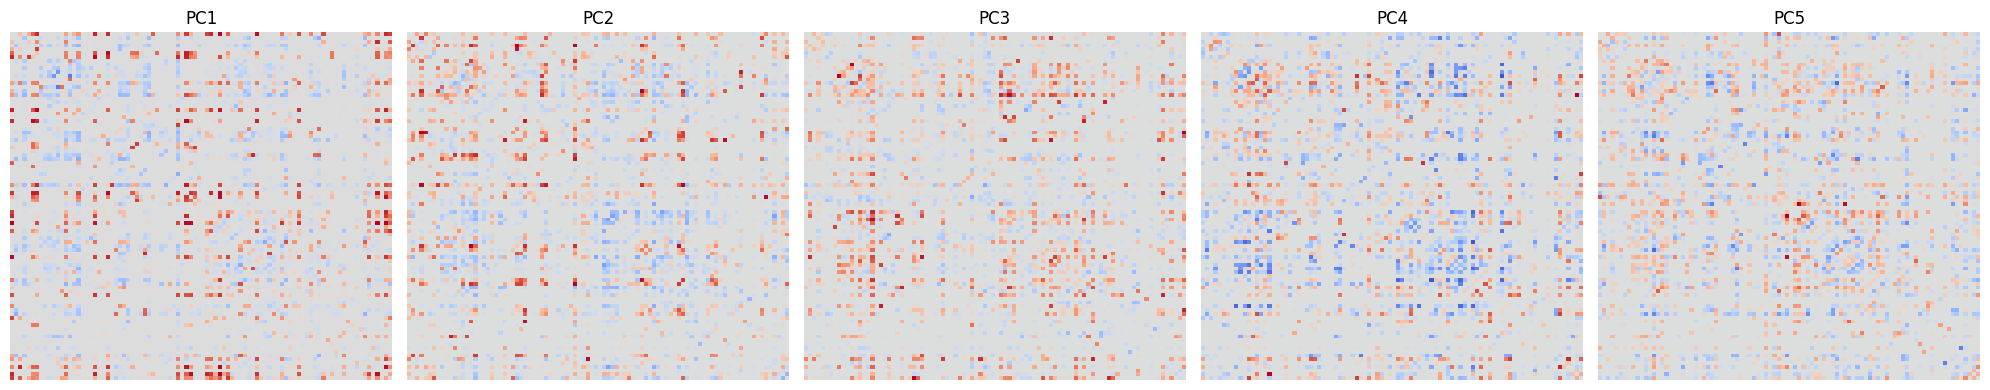

In [11]:
# Re-import necessary libraries after reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Regenerate sample continuous data for demonstration
temporal_graphs = binary_temporal_graphs

# Reshape and standardize
X = temporal_graphs.reshape(111, -1)
X_scaled = StandardScaler().fit_transform(X)

# Fit PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)

# Visualize first 5 PCs as 92x92 matrices
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    pc_matrix = pca.components_[i].reshape(92, 92)
    sns.heatmap(pc_matrix, ax=axes[i], cmap='coolwarm', center=0, cbar=False)
    axes[i].set_title(f'PC{i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [12]:
pc1 = pca.components_[4].reshape(92, 92)

strongest_pos = np.unravel_index(np.argmax(pc1), pc1.shape)
strongest_neg = np.unravel_index(np.argmin(pc1), pc1.shape)

print("PC1 max positive:", strongest_pos)
print("PC1 max negetive:", strongest_neg)


PC1 max positive: (np.int64(45), np.int64(48))
PC1 max negetive: (np.int64(13), np.int64(57))


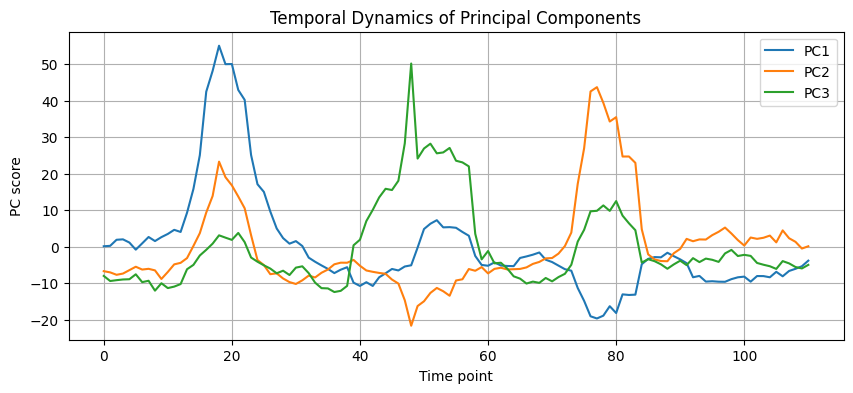

In [13]:
X_pca = pca.transform(X_scaled)  # shape: (111, 5)
plt.figure(figsize=(10, 4))
plt.plot(X_pca[:, 0], label="PC1")
plt.plot(X_pca[:, 1], label="PC2")
plt.plot(X_pca[:, 2], label="PC3")
plt.legend()
plt.title("Temporal Dynamics of Principal Components")
plt.xlabel("Time point")
plt.ylabel("PC score")
plt.grid(True)
plt.show()
